# Real-Fake Detection Training - CSV-Based Implementation

## Overview
This notebook trains a deep learning model to detect real vs fake (inpainted) images using:
- **CSV-based data splits** (no random splitting)
- **ResNet50** architecture with ImageNet pretrained weights
- **Comprehensive error analysis** on fake images (domain, mask, quality metrics, generative model)
- **Real-time GPU monitoring** during training
- **10+ detailed visualizations** for model performance analysis

## Key Features
- Enhanced progress bar with GPU stats, learning rate, and ETA
- Best model tracking (saves best_model.pth)
- Exhaustive misclassified fake images analysis
- Quality metrics correlation (SSIM, LPIPS, MSE)
- Domain/Mask/Generative Model accuracy breakdowns

## Data
- **Fake images**: ADE20K, CelebAHQ, CityScapes, HumanParsing, OpenImages
- **Generative models**: StableDiffusion v5, StableDiffusion XL, Kandinsky 2.2, OpenJourney
- **Training**: 75K fake + 16K real images (balanced)
- **Validation**: 16K fake + 3K real images (balanced)
- **Test**: 16K fake + 3K real images (balanced)

In [39]:
# Cell 2: Imports
import os
import sys
import time
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torchvision.models as models

from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

# Import utils from current directory
from utils import setup_device, create_training_folder, calculate_metrics, export_metrics_to_csv

# Try to import pynvml for GPU monitoring
try:
    import pynvml
    pynvml.nvmlInit()
    GPU_MONITORING = True
    print("GPU monitoring enabled (pynvml loaded successfully)")
except:
    GPU_MONITORING = False
    print("GPU monitoring not available (install nvidia-ml-py3 for GPU stats)")

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

GPU monitoring not available (install nvidia-ml-py3 for GPU stats)
PyTorch version: 2.5.1+cu121
CUDA available: True


In [40]:
import random
from glob import glob

def load_with_real_priority(split_dir, data_ratio=1.0, seed=42):

    random.seed(seed)

    # Real ve fake görselleri listele
    real_dir = os.path.join(split_dir, 'real')
    fake_dir = os.path.join(split_dir, 'fake')

    real_paths = []
    fake_paths = []

    # Recursively find all images
    for ext in ['*.png', '*.jpg', '*.jpeg', '*.PNG', '*.JPG', '*.JPEG']:
        real_paths.extend(glob(os.path.join(real_dir, '**', ext), recursive=True))
        fake_paths.extend(glob(os.path.join(fake_dir, '**', ext), recursive=True))

    total_count = len(real_paths) + len(fake_paths)
    target_count = int(total_count * data_ratio)

    print(f"\n{'='*60}")
    print(f"REAL-PRIORITY DATA LOADING: {os.path.basename(split_dir)}")
    print(f"{'='*60}")
    print(f"Available: {len(real_paths)} real + {len(fake_paths)} fake = {total_count} total")
    print(f"Data ratio: {data_ratio:.2%}")
    print(f"Target count: {target_count}")

    # Real öncelikli seçim
    if target_count >= 2 * len(real_paths):
        # Case A: Tüm real'ları al, geri kalanı fake'lerle doldur
        selected_real = real_paths  # hepsi
        fake_needed = target_count - len(real_paths)
        selected_fake = random.sample(fake_paths, min(fake_needed, len(fake_paths)))

        print(f"Strategy: Use ALL reals + fill with fakes")
        print(f"  - Using ALL {len(selected_real)} real images")
        print(f"  - Sampling {len(selected_fake)} from {len(fake_paths)} fake images")
    else:
        # Case B: Dengeli dağıt
        half_target = target_count // 2
        selected_real = random.sample(real_paths, min(half_target, len(real_paths)))
        selected_fake = random.sample(fake_paths, min(half_target, len(fake_paths)))

        print(f"Strategy: Balanced distribution")
        print(f"  - Sampling {len(selected_real)} from {len(real_paths)} real images")
        print(f"  - Sampling {len(selected_fake)} from {len(fake_paths)} fake images")

    print(f"\nFinal selection: {len(selected_real)} real + {len(selected_fake)} fake = {len(selected_real)+len(selected_fake)} total")
    total = len(selected_real) + len(selected_fake)
    print(f"Real ratio: {len(selected_real)/total:.2%}" if total > 0 else "Real ratio: N/A (no images found)")
    print(f"{'='*60}\n")

    return selected_real, selected_fake

In [41]:
# Cell 3: Hyperparameters (All Customizable)

# Training Parameters
BATCH_SIZE = 16
LEARNING_RATE = 0.001
NUM_EPOCHS = 2
WEIGHT_DECAY = 1e-4

# Scheduler Parameters
SCHEDULER_PATIENCE = 2
SCHEDULER_FACTOR = 0.5

# Data Parameters
IMAGE_SIZE = 512
USE_AUGMENTATION = True
NUM_WORKERS = 0

# DATA USAGE RATIO (0.0 to 1.0)
# Control what percentage of CSV data to use for training/val/test
TRAIN_DATA_RATIO = 0.001  # Use 100% of training data (1.0 = all, 0.1 = 10%, etc.)
VAL_DATA_RATIO = 0.001    # Use 100% of validation data
TEST_DATA_RATIO = 0.001   # Use 100% of test data

# CLASS BALANCING STRATEGY
# Choose how to handle class imbalance (more fakes than reals):
#   'undersampling': Drop excess fake samples to match real count (loses data)
#   'loss_weighting': Use all data but weight loss by inverse class frequency (no data loss, RECOMMENDED)
#   'none': Use all data without balancing (model may be biased)
CLASS_BALANCE_METHOD = 'loss_weighting'  # Recommended: 'loss_weighting'

# Loss Function Type
LOSS_TYPE = 'crossentropy'  # Options: 'crossentropy', 'focal'
FOCAL_ALPHA = 0.25  # Weight for focal loss (only used if LOSS_TYPE="focal")
FOCAL_GAMMA = 2.0   # Focusing parameter (only used if LOSS_TYPE="focal")

# RESUME TRAINING FROM CHECKPOINT
# Set to True to continue training from models/latest_model.pth
# Set to False to start fresh training from ImageNet pretrained weights
RESUME_FROM_CHECKPOINT = False

# Paths
FAKE_TRAIN_CSV = 'dataset_splits/fake_only_split/fake_train.csv'
FAKE_VAL_CSV = 'dataset_splits/fake_only_split/fake_val.csv'
FAKE_TEST_CSV = 'dataset_splits/fake_only_split/fake_test.csv'

REAL_TRAIN_CSV = 'dataset_splits/real_only_split/real_train.csv'
REAL_VAL_CSV = 'dataset_splits/real_only_split/real_val.csv'
REAL_TEST_CSV = 'dataset_splits/real_only_split/real_test.csv'

# Output folder
NOTEBOOK_NAME = 'real_fake_detection_csv'

# Random seed for reproducibility
RANDOM_SEED = 42

# Set seeds
torch.manual_seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(RANDOM_SEED)

print("="*60)
print("HYPERPARAMETERS")
print("="*60)
print(f"Batch Size: {BATCH_SIZE}")
print(f"Learning Rate: {LEARNING_RATE}")
print(f"Epochs: {NUM_EPOCHS}")
print(f"Weight Decay: {WEIGHT_DECAY}")
print(f"Image Size: {IMAGE_SIZE}x{IMAGE_SIZE}")
print(f"Augmentation: {USE_AUGMENTATION}")
print(f"Scheduler Patience: {SCHEDULER_PATIENCE}")
print(f"Scheduler Factor: {SCHEDULER_FACTOR}")
print("\n" + "-"*60)
print("DATA USAGE RATIOS")
print("-"*60)
print(f"Train Data Ratio: {TRAIN_DATA_RATIO*100:.1f}% of available data")
print(f"Val Data Ratio: {VAL_DATA_RATIO*100:.1f}% of available data")
print(f"Test Data Ratio: {TEST_DATA_RATIO*100:.1f}% of available data")
print("\n" + "-"*60)
print("CLASS BALANCING STRATEGY")
print("-"*60)
print(f"Method: {CLASS_BALANCE_METHOD}")
if CLASS_BALANCE_METHOD == 'loss_weighting':
    print("  ✅ Using loss weighting (no data loss, RECOMMENDED)")
elif CLASS_BALANCE_METHOD == 'undersampling':
    print("  ⚠️  Using undersampling (data loss)")
else:
    print("  ⚠️  No balancing (model may be biased)")
print("\n" + "-"*60)
print("CHECKPOINT RESUME")
print("-"*60)
print(f"Resume from checkpoint: {RESUME_FROM_CHECKPOINT}")
if RESUME_FROM_CHECKPOINT:
    print("  📂 Will resume from models/latest_model.pth")
else:
    print("  🆕 Starting fresh training from ImageNet weights")
print("="*60)

HYPERPARAMETERS
Batch Size: 16
Learning Rate: 0.001
Epochs: 2
Weight Decay: 0.0001
Image Size: 512x512
Augmentation: True
Scheduler Patience: 2
Scheduler Factor: 0.5

------------------------------------------------------------
DATA USAGE RATIOS
------------------------------------------------------------
Train Data Ratio: 0.1% of available data
Val Data Ratio: 0.1% of available data
Test Data Ratio: 0.1% of available data

------------------------------------------------------------
CLASS BALANCING STRATEGY
------------------------------------------------------------
Method: loss_weighting
  ✅ Using loss weighting (no data loss, RECOMMENDED)

------------------------------------------------------------
CHECKPOINT RESUME
------------------------------------------------------------
Resume from checkpoint: False
  🆕 Starting fresh training from ImageNet weights


In [42]:
# Cell 4: GPU Setup and Folder Creation

# Setup device
device = setup_device()

# CRITICAL: Verify CUDA is actually being used
if not torch.cuda.is_available():
    raise RuntimeError("❌ CUDA is not available! GPU training is required.")

print(f"✅ Using device: {device}")
print(f"✅ CUDA is available: {torch.cuda.is_available()}")
print(f"✅ Current CUDA device: {torch.cuda.current_device()}")
print(f"✅ Device count: {torch.cuda.device_count()}")

# Create training folder structure with versioning
base_dir, models_dir, data_dir, viz_dir, version = create_training_folder(NOTEBOOK_NAME)

print(f"\n{'='*60}")
print(f"TRAINING SESSION: {NOTEBOOK_NAME} - Version {version}")
print(f"{'='*60}")
print(f"Base directory: {base_dir}")
print(f"Models directory: {models_dir}")
print(f"Data directory: {data_dir}")
print(f"Visualizations directory: {viz_dir}")
print(f"{'='*60}\n")

# Verify directories exist
print("DIRECTORY VERIFICATION:")
print(f"  Models dir exists: {os.path.exists(models_dir)} ✅" if os.path.exists(models_dir) else f"  Models dir exists: {os.path.exists(models_dir)} ❌")
print(f"  Data dir exists: {os.path.exists(data_dir)} ✅" if os.path.exists(data_dir) else f"  Data dir exists: {os.path.exists(data_dir)} ❌")
print(f"  Viz dir exists: {os.path.exists(viz_dir)} ✅" if os.path.exists(viz_dir) else f"  Viz dir exists: {os.path.exists(viz_dir)} ❌")

# Display detailed GPU info
print("\nGPU INFORMATION:")
print(f"  GPU Name: {torch.cuda.get_device_name(0)}")
print(f"  GPU Memory Total: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.2f} GB")
print(f"  GPU Memory Allocated: {torch.cuda.memory_allocated(0) / 1024**3:.2f} GB")
print(f"  GPU Memory Cached: {torch.cuda.memory_reserved(0) / 1024**3:.2f} GB")

# GPU monitoring setup
if GPU_MONITORING:
    try:
        gpu_handle = pynvml.nvmlDeviceGetHandleByIndex(0)
        gpu_name = pynvml.nvmlDeviceGetName(gpu_handle)
        print(f"  pynvml GPU Device: {gpu_name}")
        
        mem_info = pynvml.nvmlDeviceGetMemoryInfo(gpu_handle)
        print(f"  GPU Memory Used: {mem_info.used / 1024**3:.2f} GB / {mem_info.total / 1024**3:.2f} GB")
        print(f"  GPU Memory Free: {mem_info.free / 1024**3:.2f} GB")
    except Exception as e:
        print(f"  pynvml monitoring failed: {e}")
        GPU_MONITORING = False

print("\n" + "="*60)
print("🚀 GPU VERIFICATION COMPLETE - TRAINING WILL USE GPU")
print("="*60)

✅ GPU kullanılıyor: NVIDIA GeForce RTX 4060 Laptop GPU
✅ Using device: cuda
✅ CUDA is available: True
✅ Current CUDA device: 0
✅ Device count: 1
✅ Klasör yapısı oluşturuldu:
   Models: eğitim_sonuçları\real_fake_detection_csv\models (versiyonsuz - best/latest)
   Data:   eğitim_sonuçları\real_fake_detection_csv\veriler\v31 (v31)
   Viz:    eğitim_sonuçları\real_fake_detection_csv\görseller\v31 (v31)

TRAINING SESSION: real_fake_detection_csv - Version 31
Base directory: eğitim_sonuçları\real_fake_detection_csv
Models directory: eğitim_sonuçları\real_fake_detection_csv\models
Data directory: eğitim_sonuçları\real_fake_detection_csv\veriler\v31
Visualizations directory: eğitim_sonuçları\real_fake_detection_csv\görseller\v31

DIRECTORY VERIFICATION:
  Models dir exists: True ✅
  Data dir exists: True ✅
  Viz dir exists: True ✅

GPU INFORMATION:
  GPU Name: NVIDIA GeForce RTX 4060 Laptop GPU
  GPU Memory Total: 8.00 GB
  GPU Memory Allocated: 0.70 GB
  GPU Memory Cached: 8.12 GB

🚀 GPU VER

In [43]:
# Cell 5: RealFakeCSVDataset Class

class RealFakeCSVDataset(Dataset):
    """
    Dataset that loads real and fake images from CSV files.
    Returns: (image, label, metadata_dict)
    
    Labels:
        0 = Real
        1 = Fake
    
    Metadata:
        - Fake: perturbed_img_id, mask_name, domain, ssim, lpips_score, mse,
                model_name, dataset, area_ratio, sem_magnitude
        - Real: real_img_id, parent_dataset
    """
    
    def __init__(self, fake_csv_path, real_csv_path, transform=None, 
                 balance_method='loss_weighting', data_ratio=1.0, seed=42):
        """
        Args:
            fake_csv_path: Path to fake images CSV
            real_csv_path: Path to real images CSV
            transform: Image transformations
            balance_method: 'undersampling', 'loss_weighting', or 'none'
            data_ratio: Percentage of data to use (0.0 to 1.0)
            seed: Random seed for reproducibility
        """
        self.transform = transform
        self.balance_method = balance_method
        
        # Load CSV files
        print(f"Loading fake CSV: {fake_csv_path}")
        fake_df = pd.read_csv(fake_csv_path)
        print(f"  Loaded {len(fake_df):,} fake images from CSV")
        
        print(f"Loading real CSV: {real_csv_path}")
        real_df = pd.read_csv(real_csv_path)
        print(f"  Loaded {len(real_df):,} real images from CSV")
        
        # Apply data ratio with REAL-PRIORITY strategy
        if data_ratio < 1.0:
            print(f"\n⚙️  Applying data ratio: {data_ratio*100:.1f}% (REAL-PRIORITY)")
            
            total_images = len(fake_df) + len(real_df)
            target_size = int(total_images * data_ratio)
            real_count = len(real_df)
            fake_count = len(fake_df)
            
            print(f"  Total available: {total_images:,} ({real_count:,} real + {fake_count:,} fake)")
            print(f"  Target size: {target_size:,}")
            
            # REAL-PRIORITY LOGIC
            if target_size >= 2 * real_count:
                # Use ALL real images + fill rest with fakes
                selected_real_count = real_count
                selected_fake_count = min(target_size - real_count, fake_count)
                
                real_df = real_df.copy()  # Keep all reals
                fake_df = fake_df.sample(n=selected_fake_count, random_state=seed).reset_index(drop=True)
                
                print(f"  ✅ Strategy: ALL REALS + sampled fakes")
                print(f"     Real: {selected_real_count:,} (100% of available)")
                print(f"     Fake: {selected_fake_count:,} ({selected_fake_count/fake_count*100:.1f}% of available)")
            else:
                # Balanced distribution
                half_target = target_size // 2
                selected_real_count = min(half_target, real_count)
                selected_fake_count = min(half_target, fake_count)
                
                real_df = real_df.sample(n=selected_real_count, random_state=seed).reset_index(drop=True)
                fake_df = fake_df.sample(n=selected_fake_count, random_state=seed).reset_index(drop=True)
                
                print(f"  ✅ Strategy: BALANCED distribution")
                print(f"     Real: {selected_real_count:,} (~50%)")
                print(f"     Fake: {selected_fake_count:,} (~50%)")
            
            actual_total = len(real_df) + len(fake_df)
            real_ratio = len(real_df) / actual_total if actual_total > 0 else 0
            print(f"  📊 Final: {len(real_df):,} real + {len(fake_df):,} fake = {actual_total:,}")
            print(f"     Real ratio: {real_ratio*100:.1f}%")
        
        # Store original counts for class weighting (BEFORE balancing)
        self.num_real = len(real_df)
        self.num_fake = len(fake_df)
        
        # Apply balancing strategy
        if balance_method == 'undersampling':
            min_count = min(len(fake_df), len(real_df))
            print(f"\n⚖️  Undersampling to {min_count:,} samples each...")
            
            fake_df = fake_df.sample(n=min_count, random_state=seed).reset_index(drop=True)
            real_df = real_df.sample(n=min_count, random_state=seed).reset_index(drop=True)
            
            print(f"  Fake images after undersampling: {len(fake_df):,}")
            print(f"  Real images after undersampling: {len(real_df):,}")
            print(f"  ⚠️  Data loss: {self.num_fake - len(fake_df):,} fake images dropped")
            
        elif balance_method == 'loss_weighting':
            print(f"\n⚖️  Using loss weighting (keeping all data)")
            print(f"  Real: {len(real_df):,} | Fake: {len(fake_df):,}")
            print(f"  ✅ No data loss - imbalance handled by loss weights")
            
        else:  # 'none'
            print(f"\n⚠️  No balancing applied")
            print(f"  Real: {len(real_df):,} | Fake: {len(fake_df):,}")
            print(f"  Imbalance ratio: {len(fake_df)/len(real_df):.2f}x more fakes")
        
        # Prepare data list
        self.data = []
        
        # Add fake images (label = 1)
        for idx, row in fake_df.iterrows():
            metadata = {
                'label_name': 'fake',
                'perturbed_img_id': row.get('perturbed_img_id', ''),
                'real_img_id': row.get('real_img_id', ''),
                'mask_name': row.get('mask_name', ''),
                'domain': row.get('domain', ''),
                'ssim': row.get('ssim', 0.0),
                'lpips_score': row.get('lpips_score', 0.0),
                'mse': row.get('mse', 0.0),
                'model_name': row.get('model_name', ''),
                'dataset': row.get('dataset', ''),
                'area_ratio': row.get('area_ratio', 0.0),
                'sem_magnitude': row.get('sem_magnitude', 0.0)
            }
            self.data.append((row['fake_img_path'], 1, metadata))
        
        # Add real images (label = 0)
        for idx, row in real_df.iterrows():
            metadata = {
                'label_name': 'real',
                'real_img_id': row.get('real_img_id', ''),
                'parent_dataset': row.get('parent_dataset', '')
            }
            self.data.append((row['real_img_path'], 0, metadata))
        
        print(f"\n📊 Final dataset size: {len(self.data):,} images")
        print(f"  Real: {len(real_df):,} ({len(real_df)/len(self.data)*100:.1f}%)")
        print(f"  Fake: {len(fake_df):,} ({len(fake_df)/len(self.data)*100:.1f}%)")
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        img_path, label, metadata = self.data[idx]
        
        # Load image
        try:
            image = Image.open(img_path).convert('RGB')
        except Exception as e:
            print(f"Error loading image {img_path}: {e}")
            # Return a black image as fallback
            image = Image.new('RGB', (224, 224), (0, 0, 0))
        
        # Apply transforms
        if self.transform:
            image = self.transform(image)
        
        return image, label, metadata
    
    def get_class_weights(self):
        """
        Calculate class weights using direct ratio (most aggressive).
        Returns: torch.FloatTensor: Weights for [real, fake] classes
        """
        imbalance_ratio = self.num_fake / self.num_real
        print(f"\n⚖️  Class Imbalance: {imbalance_ratio:.2f}x more fakes")
        
        # Calculate weights
        total = self.num_real + self.num_fake
        weight_real_v1 = total / (2.0 * self.num_real)  # Standard
        weight_fake_v1 = total / (2.0 * self.num_fake)
        weight_real_v3 = imbalance_ratio  # Direct ratio (USED)
        weight_fake_v3 = 1.0
        
        print(f"  Standard: Real={weight_real_v1:.4f}, Fake={weight_fake_v1:.4f}")
        print(f"  Direct:   Real={weight_real_v3:.4f}, Fake={weight_fake_v3:.4f} ← USING THIS")
        return torch.FloatTensor([weight_real_v3, weight_fake_v3])

print("RealFakeCSVDataset class defined successfully!")

RealFakeCSVDataset class defined successfully!


In [44]:
# Cell 6: Data Transforms

# Training transforms with augmentation
if USE_AUGMENTATION:
    train_transform = transforms.Compose([
        transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomRotation(degrees=15),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                           std=[0.229, 0.224, 0.225])
    ])
    print("Training transforms: WITH augmentation")
else:
    train_transform = transforms.Compose([
        transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                           std=[0.229, 0.224, 0.225])
    ])
    print("Training transforms: WITHOUT augmentation")

# Validation and test transforms (no augmentation)
eval_transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                       std=[0.229, 0.224, 0.225])
])

print("Validation/Test transforms: Basic resize + normalize")
print(f"Image size: {IMAGE_SIZE}x{IMAGE_SIZE}")
print(f"Normalization: ImageNet statistics")

Training transforms: WITH augmentation
Validation/Test transforms: Basic resize + normalize
Image size: 512x512
Normalization: ImageNet statistics


In [45]:
# Cell 7: Load Datasets and Create DataLoaders

print("="*60)
print("LOADING DATASETS")
print("="*60)

# Training dataset
print("\nTRAINING SET:")
train_dataset = RealFakeCSVDataset(
    fake_csv_path=FAKE_TRAIN_CSV,
    real_csv_path=REAL_TRAIN_CSV,
    transform=train_transform,
    balance_method=CLASS_BALANCE_METHOD,
    data_ratio=TRAIN_DATA_RATIO,
    seed=RANDOM_SEED
)

# Validation dataset
print("\n" + "="*60)
print("VALIDATION SET:")
val_dataset = RealFakeCSVDataset(
    fake_csv_path=FAKE_VAL_CSV,
    real_csv_path=REAL_VAL_CSV,
    transform=eval_transform,
    balance_method=CLASS_BALANCE_METHOD,
    data_ratio=VAL_DATA_RATIO,
    seed=RANDOM_SEED
)

# Test dataset
print("\n" + "="*60)
print("TEST SET:")
test_dataset = RealFakeCSVDataset(
    fake_csv_path=FAKE_TEST_CSV,
    real_csv_path=REAL_TEST_CSV,
    transform=eval_transform,
    balance_method=CLASS_BALANCE_METHOD,
    data_ratio=TEST_DATA_RATIO,
    seed=RANDOM_SEED
)

# Calculate class weights if using loss weighting
if CLASS_BALANCE_METHOD == 'loss_weighting':
    class_weights = train_dataset.get_class_weights()
    print("\n" + "="*60)
    print("CLASS WEIGHTS FOR LOSS FUNCTION")
    print("="*60)
    print(f"Real (class 0) weight: {class_weights[0]:.4f}")
    print(f"Fake (class 1) weight: {class_weights[1]:.4f}")
    print(f"\nInterpretation:")
    print(f"  - Real images get {class_weights[0]:.2f}x weight in loss")
    print(f"  - Fake images get {class_weights[1]:.2f}x weight in loss")
    print(f"  - Higher weight for minority class compensates for imbalance")
    print("="*60)
else:
    class_weights = None

# Custom collate function to handle metadata as list instead of dict batching
def custom_collate_fn(batch):
    """
    Custom collate function that keeps metadata as a list of dicts
    instead of trying to batch them into a single dict.
    
    Args:
        batch: List of (image, label, metadata_dict) tuples
    
    Returns:
        images: Batched tensor of images
        labels: Batched tensor of labels  
        metadata: List of metadata dicts (NOT batched)
    """
    images = torch.stack([item[0] for item in batch])
    labels = torch.tensor([item[1] for item in batch])
    metadata = [item[2] for item in batch]  # Keep as list!
    
    return images, labels, metadata

# Create DataLoaders with custom collate function
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS,
    pin_memory=True if torch.cuda.is_available() else False,
    collate_fn=custom_collate_fn
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=True if torch.cuda.is_available() else False,
    collate_fn=custom_collate_fn
)

test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=True if torch.cuda.is_available() else False,
    collate_fn=custom_collate_fn
)

print("\n" + "="*60)
print("DATALOADER SUMMARY")
print("="*60)
print(f"Train batches: {len(train_loader)}")
print(f"Val batches: {len(val_loader)}")
print(f"Test batches: {len(test_loader)}")
print(f"Batch size: {BATCH_SIZE}")
print(f"Num workers: {NUM_WORKERS}")
print(f"Custom collate: Enabled (metadata as list)")
print("="*60)

LOADING DATASETS

TRAINING SET:
Loading fake CSV: dataset_splits/fake_only_split/fake_train.csv
  Loaded 75,154 fake images from CSV
Loading real CSV: dataset_splits/real_only_split/real_train.csv
  Loaded 16,627 real images from CSV

⚙️  Applying data ratio: 0.1% (REAL-PRIORITY)
  Total available: 91,781 (16,627 real + 75,154 fake)
  Target size: 91
  ✅ Strategy: BALANCED distribution
     Real: 45 (~50%)
     Fake: 45 (~50%)
  📊 Final: 45 real + 45 fake = 90
     Real ratio: 50.0%

⚖️  Using loss weighting (keeping all data)
  Real: 45 | Fake: 45
  ✅ No data loss - imbalance handled by loss weights

📊 Final dataset size: 90 images
  Real: 45 (50.0%)
  Fake: 45 (50.0%)

VALIDATION SET:
Loading fake CSV: dataset_splits/fake_only_split/fake_val.csv
  Loaded 16,291 fake images from CSV
Loading real CSV: dataset_splits/real_only_split/real_val.csv
  Loaded 3,569 real images from CSV

⚙️  Applying data ratio: 0.1% (REAL-PRIORITY)
  Total available: 19,860 (3,569 real + 16,291 fake)
  Targe

In [46]:
# Cell 8: Model Definition

class RealFakeModel(nn.Module):
    """
    ResNet50-based binary classifier for real vs fake image detection.

    Architecture:
        - Backbone: ResNet50 pretrained on ImageNet
        - Classifier: Single FC layer (2048 -> 2 classes)
    """

    def __init__(self, pretrained=True):
        super(RealFakeModel, self).__init__()

        # Load pretrained ResNet50
        self.resnet = models.resnet50(pretrained=pretrained)

        # Get number of features from the last layer
        num_features = self.resnet.fc.in_features

        # Replace final FC layer for binary classification
        self.resnet.fc = nn.Linear(num_features, 2)

    def forward(self, x):
        return self.resnet(x)

# Initialize model
model = RealFakeModel(pretrained=True).to(device)

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print("="*60)
print("MODEL ARCHITECTURE")
print("="*60)
print(f"Model: ResNet50 (pretrained on ImageNet)")
print(f"Output classes: 2 (Real, Fake)")
print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")
print(f"Device: {device}")
print("="*60)

# Variables to store resume info
resume_checkpoint_path = None
start_epoch = 0
resume_best_val_acc = 0.0

# Check if we should resume from checkpoint
if RESUME_FROM_CHECKPOINT:
    print("\n" + "="*60)
    print("LOADING CHECKPOINT")
    print("="*60)

    # Determine checkpoint path
    base_results_dir = f"eğitim_sonuçları/{NOTEBOOK_NAME}"
    resume_checkpoint_path = os.path.join(base_results_dir, "models/latest_model.pth")

    if os.path.exists(resume_checkpoint_path):
        print(f"📂 Found checkpoint: {resume_checkpoint_path}")
    else:
        print(f"❌ No checkpoint found at: {resume_checkpoint_path}")
        print("   Starting fresh training.")
        RESUME_FROM_CHECKPOINT = False

    # Load checkpoint if path exists
    if RESUME_FROM_CHECKPOINT and resume_checkpoint_path and os.path.exists(resume_checkpoint_path):
        print(f"📥 Loading checkpoint from: {resume_checkpoint_path}")

        try:
            checkpoint = torch.load(resume_checkpoint_path, map_location=device)
            model.load_state_dict(checkpoint['model_state_dict'])

            start_epoch = checkpoint.get('epoch', 0) + 1
            resume_best_val_acc = checkpoint.get('val_acc', 0.0)

            print(f"✅ Checkpoint loaded successfully!")
            print(f"   Previous epoch: {checkpoint.get('epoch', 0)}")
            print(f"   Previous val_acc: {resume_best_val_acc:.4f}")
            print(f"   Previous val_loss: {checkpoint.get('val_loss', 0.0):.4f}")
            print(f"   Will continue from epoch: {start_epoch + 1}")

        except Exception as e:
            print(f"❌ Error loading checkpoint: {e}")
            print("   Starting fresh training instead.")
            RESUME_FROM_CHECKPOINT = False
            start_epoch = 0
            resume_best_val_acc = 0.0

    elif RESUME_FROM_CHECKPOINT:
        print(f"❌ Checkpoint not found at: {resume_checkpoint_path}")
        print("   Starting fresh training instead.")
        RESUME_FROM_CHECKPOINT = False
        start_epoch = 0
        resume_best_val_acc = 0.0

    print("="*60)

if not RESUME_FROM_CHECKPOINT:
    print(f"\n🆕 Starting fresh training from ImageNet pretrained weights")


MODEL ARCHITECTURE
Model: ResNet50 (pretrained on ImageNet)
Output classes: 2 (Real, Fake)
Total parameters: 23,512,130
Trainable parameters: 23,512,130
Device: cuda

🆕 Starting fresh training from ImageNet pretrained weights


In [47]:
# Cell 8.5: Focal Loss Implementation (Optional - Better for Class Imbalance)

class FocalLoss(nn.Module):
    """
    Focal Loss for addressing class imbalance.

    Formula: FL(p_t) = -alpha_t * (1 - p_t)^gamma * log(p_t)

    where:
        - p_t is the model's estimated probability for the correct class
        - alpha_t is the class weight (like in weighted CE)
        - gamma is the focusing parameter (default=2.0)
            - gamma=0: Focal Loss = CrossEntropyLoss
            - gamma>0: Reduces loss for well-classified examples

    Key Advantage over Weighted CrossEntropy:
        - Weighted CE treats all examples equally regardless of difficulty
        - Focal Loss down-weights easy examples and focuses on hard negatives
        - For severe imbalance, this prevents the model from being
          overwhelmed by easy majority-class examples

    Reference: https://arxiv.org/abs/1708.02002
    """

    def __init__(self, alpha=None, gamma=2.0, reduction='mean'):
        """
        Args:
            alpha: Class weights tensor [weight_class0, weight_class1, ...]
                   If None, all classes weighted equally
            gamma: Focusing parameter. Higher = more focus on hard examples
            reduction: 'mean', 'sum', or 'none'
        """
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        """
        Args:
            inputs: Model logits [batch_size, num_classes]
            targets: Ground truth labels [batch_size]
        """
        # Get probabilities using softmax
        p = torch.softmax(inputs, dim=1)

        # Get cross entropy loss (without reduction)
        ce_loss = F.cross_entropy(inputs, targets, reduction='none')

        # Get probability of the correct class for each sample
        p_t = p.gather(1, targets.view(-1, 1)).squeeze(1)

        # Calculate focal term: (1 - p_t)^gamma
        focal_term = (1 - p_t) ** self.gamma

        # Calculate focal loss
        focal_loss = focal_term * ce_loss

        # Apply class weights if provided
        if self.alpha is not None:
            alpha_t = self.alpha.gather(0, targets)
            focal_loss = alpha_t * focal_loss

        # Apply reduction
        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else:
            return focal_loss

print("FocalLoss class defined successfully!")
print("\nFocal Loss advantages for class imbalance:")
print("  1. Down-weights easy examples (high confidence)")
print("  2. Focuses training on hard examples (low confidence)")
print("  3. Prevents majority class from dominating training")
print("  4. Combines class weighting (alpha) with difficulty weighting (gamma)")


FocalLoss class defined successfully!

Focal Loss advantages for class imbalance:
  1. Down-weights easy examples (high confidence)
  2. Focuses training on hard examples (low confidence)
  3. Prevents majority class from dominating training
  4. Combines class weighting (alpha) with difficulty weighting (gamma)


In [48]:
# Cell 9: Loss, Optimizer, Scheduler, and History

# Loss function selection: CrossEntropy vs Focal Loss
print("="*60)
print("LOSS FUNCTION CONFIGURATION")
print("="*60)
print(f"Loss type: {LOSS_TYPE}")
print(f"Balance method: {CLASS_BALANCE_METHOD}")

if LOSS_TYPE == 'focal':
    # Use Focal Loss (better for severe class imbalance)
    if CLASS_BALANCE_METHOD == 'loss_weighting' and class_weights is not None:
        class_weights_gpu = class_weights.to(device)
        criterion = FocalLoss(alpha=class_weights_gpu, gamma=FOCAL_GAMMA)
        print(f"\n✅ Using FOCAL LOSS with class weights")
        print(f"  Alpha (class weights): Real={class_weights[0]:.4f}, Fake={class_weights[1]:.4f}")
        print(f"  Gamma (focusing param): {FOCAL_GAMMA}")
        print(f"\n  How Focal Loss works:")
        print(f"    1. Easy examples (high confidence) → low loss")
        print(f"    2. Hard examples (low confidence) → high loss")
        print(f"    3. Prevents majority class easy examples from dominating")
        print(f"    4. Ideal for severe class imbalance (4-5x or more)")
    else:
        criterion = FocalLoss(alpha=None, gamma=FOCAL_GAMMA)
        print(f"\n✅ Using FOCAL LOSS without class weights")
        print(f"  Gamma: {FOCAL_GAMMA}")
else:
    # Use standard CrossEntropy Loss
    if CLASS_BALANCE_METHOD == 'loss_weighting' and class_weights is not None:
        class_weights_gpu = class_weights.to(device)
        criterion = nn.CrossEntropyLoss(weight=class_weights_gpu)
        print(f"\n✅ Using CrossEntropyLoss WITH class weights")
        print(f"  Real (class 0) weight: {class_weights[0]:.4f}")
        print(f"  Fake (class 1) weight: {class_weights[1]:.4f}")
        print(f"\n  How it works:")
        print(f"    - Loss for each sample multiplied by its class weight")
        print(f"    - Minority class (real) errors penalized more heavily")
        print(f"    - Prevents model bias toward majority class")
    else:
        criterion = nn.CrossEntropyLoss()
        print(f"\n✅ Using CrossEntropyLoss (no class weights)")
        print(f"  ⚠️  No imbalance handling - may bias toward majority class")

print("="*60)

# Optimizer
optimizer = optim.Adam(
    model.parameters(),
    lr=LEARNING_RATE,
    weight_decay=WEIGHT_DECAY
)

# Load optimizer state if resuming from checkpoint
if RESUME_FROM_CHECKPOINT and resume_checkpoint_path and os.path.exists(resume_checkpoint_path):
    try:
        checkpoint = torch.load(resume_checkpoint_path, map_location=device)
        if 'optimizer_state_dict' in checkpoint:
            optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
            print(f"\n✅ Optimizer state loaded from checkpoint")
    except Exception as e:
        print(f"\n⚠️  Could not load optimizer state: {e}")
        print("   Optimizer will start with fresh state")

# Learning rate scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='max',
    patience=SCHEDULER_PATIENCE,
    factor=SCHEDULER_FACTOR)

# Training history
history = {
    'train_loss': [],
    'train_acc': [],
    'val_loss': [],
    'val_acc': [],
    'lr': []
}

print("\n" + "="*60)
print("TRAINING CONFIGURATION")
print("="*60)
print(f"Optimizer: Adam")
print(f"  Learning rate: {LEARNING_RATE}")
print(f"  Weight decay: {WEIGHT_DECAY}")
print(f"Scheduler: ReduceLROnPlateau")
print(f"  Mode: max (validation accuracy)")
print(f"  Patience: {SCHEDULER_PATIENCE} epochs")
print(f"  Factor: {SCHEDULER_FACTOR}")
print(f"Class balancing: {CLASS_BALANCE_METHOD}")
if RESUME_FROM_CHECKPOINT:
    print(f"Resume training: YES (starting from epoch {start_epoch + 1})")
    print(f"Previous best val_acc: {resume_best_val_acc:.4f}")
else:
    print(f"Resume training: NO (fresh start)")
print("="*60)

LOSS FUNCTION CONFIGURATION
Loss type: crossentropy
Balance method: loss_weighting

✅ Using CrossEntropyLoss WITH class weights
  Real (class 0) weight: 1.0000
  Fake (class 1) weight: 1.0000

  How it works:
    - Loss for each sample multiplied by its class weight
    - Minority class (real) errors penalized more heavily
    - Prevents model bias toward majority class

TRAINING CONFIGURATION
Optimizer: Adam
  Learning rate: 0.001
  Weight decay: 0.0001
Scheduler: ReduceLROnPlateau
  Mode: max (validation accuracy)
  Patience: 2 epochs
  Factor: 0.5
Class balancing: loss_weighting
Resume training: NO (fresh start)


In [49]:
# Cell 10: GPU Monitoring Helper Functions

def get_gpu_stats():
    """
    Get GPU memory and utilization statistics.
    Returns: (memory_utilization%, gpu_utilization%)
    """
    if not GPU_MONITORING:
        return 0.0, 0.0
    
    try:
        mem_info = pynvml.nvmlDeviceGetMemoryInfo(gpu_handle)
        utilization = pynvml.nvmlDeviceGetUtilizationRates(gpu_handle)
        
        mem_util = (mem_info.used / mem_info.total) * 100
        gpu_util = utilization.gpu
        
        return mem_util, gpu_util
    except:
        return 0.0, 0.0

def format_time(seconds):
    """
    Format seconds to HH:MM:SS.
    """
    hours = int(seconds // 3600)
    minutes = int((seconds % 3600) // 60)
    secs = int(seconds % 60)
    return f"{hours:02d}:{minutes:02d}:{secs:02d}"

print("GPU monitoring helper functions defined successfully!")

GPU monitoring helper functions defined successfully!


In [50]:
# Cell 11: Training Loop with Enhanced Progress Bar

print("="*60)
print("STARTING TRAINING")
print("="*60)

# CRITICAL: Verify model and data are on GPU
print(f"\n🔍 GPU VERIFICATION BEFORE TRAINING:")
print(f"  Model device: {next(model.parameters()).device}")
print(f"  Expected device: {device}")
assert next(model.parameters()).device.type == 'cuda', "❌ Model is NOT on GPU!"
print(f"  ✅ Model confirmed on GPU")

# Test a batch to verify GPU is being used
print(f"\n🔍 Testing GPU with first batch...")
first_batch = next(iter(train_loader))
test_images, test_labels, _ = first_batch
test_images = test_images.to(device)
test_labels = test_labels.to(device)
print(f"  Batch images device: {test_images.device}")
print(f"  Batch labels device: {test_labels.device}")
assert test_images.device.type == 'cuda', "❌ Data is NOT on GPU!"
print(f"  ✅ Data confirmed on GPU")
print(f"  ✅ GPU Memory allocated: {torch.cuda.memory_allocated(0) / 1024**3:.2f} GB")
print(f"\n{'='*60}")

# Best model tracking - use resume value if resuming
if RESUME_FROM_CHECKPOINT and resume_best_val_acc > 0:
    best_val_acc = resume_best_val_acc
    best_epoch = start_epoch
    print(f"\n📂 Resuming from checkpoint:")
    print(f"   Starting best_val_acc: {best_val_acc:.4f}")
    print(f"   Starting from epoch: {start_epoch + 1}")
else:
    best_val_acc = 0.0
    best_epoch = 0
    print(f"\n🆕 Starting fresh training")

# Training start time
training_start_time = time.time()

if 'train_real_acc' not in history:
    history['train_real_acc'] = []
if 'train_fake_acc' not in history:
    history['train_fake_acc'] = []

for epoch in range(start_epoch, NUM_EPOCHS):
    epoch_start_time = time.time()
    
    # Get current learning rate
    current_lr = optimizer.param_groups[0]['lr']
    history['lr'].append(current_lr)
    
    print(f"\nEpoch [{epoch+1}/{NUM_EPOCHS}] - LR: {current_lr:.6f}")
    print("-" * 60)
    
    # ==================== TRAINING PHASE ====================
    model.train()

        # Initialize running metrics
    running_loss = 0.0
    running_correct = 0
    running_samples = 0
    running_real_correct = 0
    running_real_total = 0
    running_fake_correct = 0
    running_fake_total = 0

    train_loss = 0.0
    train_correct = 0
    train_total = 0
    
    # Create progress bar for training
    train_pbar = tqdm(train_loader, desc=f"Training", unit="batch")

    # Real/Fake accuracy tracking
    running_real_correct = 0
    running_real_total = 0
    running_fake_correct = 0
    running_fake_total = 0
    
    for batch_idx, (images, labels, metadata) in enumerate(train_pbar):
        images = images.to(device)
        labels = labels.to(device)
        
        # Forward pass
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward pass
        loss.backward()
        optimizer.step()
        
        # Calculate accuracy
        _, predicted = torch.max(outputs.data, 1)
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()
        train_loss += loss.item()

        # Track real/fake accuracy
        real_mask = labels == 0
        fake_mask = labels == 1

        if real_mask.sum() > 0:
            running_real_correct += (predicted[real_mask] == labels[real_mask]).sum().item()
            running_real_total += real_mask.sum().item()

        if fake_mask.sum() > 0:
            running_fake_correct += (predicted[fake_mask] == labels[fake_mask]).sum().item()
            running_fake_total += fake_mask.sum().item()

        # Update running totals for overall metrics
        batch_size = labels.size(0)
        correct = (predicted == labels).sum().item()

        running_loss += loss.item() * batch_size
        running_correct += correct
        running_samples += batch_size
        
        # Calculate running metrics
        avg_loss = train_loss / (batch_idx + 1)
        current_acc = train_correct / train_total
        
        # Get GPU stats
        mem_util, gpu_util = get_gpu_stats()
        
        # Estimate time remaining
        batches_done = batch_idx + 1
        batches_left = len(train_loader) - batches_done
        batch_time = (time.time() - epoch_start_time) / batches_done
        eta_seconds = batch_time * batches_left
        
        # Calculate running accuracies
        running_acc = running_correct / running_samples if running_samples > 0 else 0
        running_real_acc = running_real_correct / running_real_total if running_real_total > 0 else 0
        running_fake_acc = running_fake_correct / running_fake_total if running_fake_total > 0 else 0

        # Update progress bar
        train_pbar.set_postfix({
            'loss': f'{running_loss/running_samples:.4f}',
            'acc': f'{running_acc:.2%}',
            'real': f'{running_real_acc:.2%}',
            'fake': f'{running_fake_acc:.2%}'
        })
    
    # Calculate epoch training metrics
        epoch_train_loss = running_loss / running_samples if running_samples > 0 else 0
        epoch_train_acc = running_correct / running_samples if running_samples > 0 else 0
        epoch_real_acc = running_real_correct / running_real_total if running_real_total > 0 else 0
    epoch_fake_acc = running_fake_correct / running_fake_total if running_fake_total > 0 else 0
    history['train_loss'].append(epoch_train_loss)
    history['train_acc'].append(epoch_train_acc)
    history['train_real_acc'].append(epoch_real_acc)
    history['train_fake_acc'].append(epoch_fake_acc)
    
    # ==================== VALIDATION PHASE ====================
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    
    val_pbar = tqdm(val_loader, desc=f"Validation", unit="batch")
    
    with torch.no_grad():
        for batch_idx, (images, labels, metadata) in enumerate(val_pbar):
            images = images.to(device)
            labels = labels.to(device)
            
            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            # Calculate accuracy
            _, predicted = torch.max(outputs.data, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()
            val_loss += loss.item()
            
            # Calculate running metrics
            avg_loss = val_loss / (batch_idx + 1)
            current_acc = val_correct / val_total
            
            # Update progress bar
            val_pbar.set_postfix({
                'Loss': f'{avg_loss:.4f}',
                'Acc': f'{current_acc:.3f}'
            })
    
    # Calculate epoch validation metrics
    epoch_val_loss = val_loss / len(val_loader)
    epoch_val_acc = val_correct / val_total
    
    history['val_loss'].append(epoch_val_loss)
    history['val_acc'].append(epoch_val_acc)
    
    # Print epoch summary
    epoch_time = time.time() - epoch_start_time
    print(f"\nEpoch [{epoch+1}/{NUM_EPOCHS}] Summary:")
    print(f"  Train Loss: {epoch_train_loss:.4f} | Train Acc: {epoch_train_acc:.4f}")
    print(f"  Val Loss: {epoch_val_loss:.4f} | Val Acc: {epoch_val_acc:.4f}")
    print(f"  Time: {format_time(epoch_time)}")
    print(f"  GPU Memory: {torch.cuda.memory_allocated(0) / 1024**3:.2f} GB")
    
    # Save best model
    if epoch_val_acc > best_val_acc:
        best_val_acc = epoch_val_acc
        best_epoch = epoch + 1
        
        # Save best model checkpoint
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_acc': epoch_val_acc,
            'val_loss': epoch_val_loss
        }, os.path.join(models_dir, 'best_model.pth'))
        
        print(f"  ✅ NEW BEST MODEL SAVED! Val Acc: {epoch_val_acc:.4f}")
    
    # Always save latest checkpoint (for resuming training)
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'val_acc': epoch_val_acc,
        'val_loss': epoch_val_loss
    }, os.path.join(models_dir, 'latest_model.pth'))
    
    # Update learning rate scheduler
    scheduler.step(epoch_val_acc)
    
    print("-" * 60)

# Training complete
total_training_time = time.time() - training_start_time

print("\n" + "="*60)
print("TRAINING COMPLETE!")
print("="*60)
print(f"Total training time: {format_time(total_training_time)}")
print(f"Best validation accuracy: {best_val_acc:.4f} (Epoch {best_epoch})")
print(f"Best model saved at: {os.path.join(models_dir, 'best_model.pth')}")
print(f"Final GPU Memory: {torch.cuda.memory_allocated(0) / 1024**3:.2f} GB")
print("="*60)

STARTING TRAINING

🔍 GPU VERIFICATION BEFORE TRAINING:
  Model device: cuda:0
  Expected device: cuda
  ✅ Model confirmed on GPU

🔍 Testing GPU with first batch...
  Batch images device: cuda:0
  Batch labels device: cuda:0
  ✅ Data confirmed on GPU
  ✅ GPU Memory allocated: 0.43 GB


🆕 Starting fresh training

Epoch [1/2] - LR: 0.001000
------------------------------------------------------------


Validation: 100%|██████████| 2/2 [00:00<00:00,  3.80batch/s, Loss=43.6763, Acc=0.444]



Epoch [1/2] Summary:
  Train Loss: 0.9142 | Train Acc: 0.5222
  Val Loss: 43.6763 | Val Acc: 0.4444
  Time: 00:00:15
  GPU Memory: 0.69 GB
  ✅ NEW BEST MODEL SAVED! Val Acc: 0.4444
------------------------------------------------------------

Epoch [2/2] - LR: 0.001000
------------------------------------------------------------


Validation: 100%|██████████| 2/2 [00:00<00:00,  3.84batch/s, Loss=5.7196, Acc=0.444]



Epoch [2/2] Summary:
  Train Loss: 0.8335 | Train Acc: 0.5667
  Val Loss: 5.7196 | Val Acc: 0.4444
  Time: 00:00:14
  GPU Memory: 0.69 GB
------------------------------------------------------------

TRAINING COMPLETE!
Total training time: 00:00:30
Best validation accuracy: 0.4444 (Epoch 1)
Best model saved at: eğitim_sonuçları\real_fake_detection_csv\models\best_model.pth
Final GPU Memory: 0.69 GB


In [51]:
# Cell 12: Save Training History

# Create history DataFrame using actual number of epochs trained
actual_epochs_trained = len(history['train_loss'])

# Calculate starting epoch number for DataFrame
if RESUME_FROM_CHECKPOINT:
    epoch_start_num = start_epoch + 1
else:
    epoch_start_num = 1

history_df = pd.DataFrame({
    'epoch': list(range(epoch_start_num, epoch_start_num + actual_epochs_trained)),
    'train_loss': history['train_loss'],
    'train_acc': history['train_acc'],
    'train_real_acc': history['train_real_acc'],
    'train_fake_acc': history['train_fake_acc'],
    'val_loss': history['val_loss'],
    'val_acc': history['val_acc'],
    'learning_rate': history['lr']
})

# Save to CSV
history_path = os.path.join(data_dir, 'training_history.csv')
history_df.to_csv(history_path, index=False)

print(f"Training history saved to: {history_path}")
print(f"\nHistory summary:")
print(f"Epochs trained in this session: {actual_epochs_trained}")
if RESUME_FROM_CHECKPOINT:
    print(f"Resumed from epoch: {start_epoch + 1}")
print(f"\nHistory data:")
print(history_df)

Training history saved to: eğitim_sonuçları\real_fake_detection_csv\veriler\v31\training_history.csv

History summary:
Epochs trained in this session: 2

History data:
   epoch  train_loss  train_acc  train_real_acc  train_fake_acc   val_loss  \
0      1    0.914235   0.522222        0.400000        0.644444  43.676285   
1      2    0.833522   0.566667        0.488889        0.644444   5.719585   

    val_acc  learning_rate  
0  0.444444          0.001  
1  0.444444          0.001  


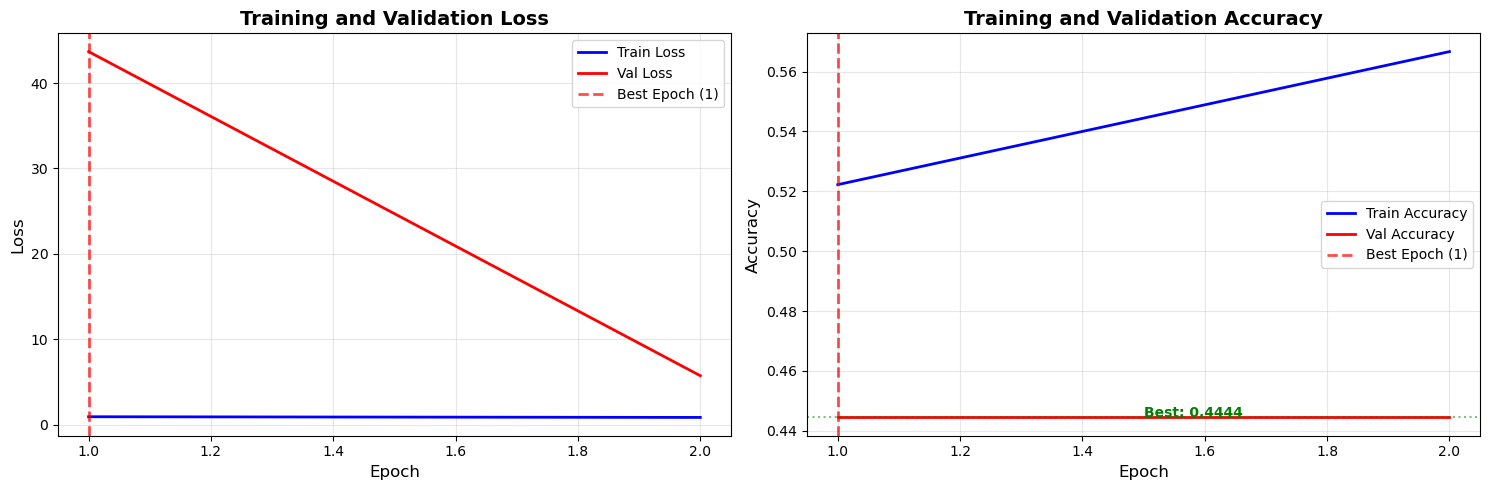

Training curves saved to: eğitim_sonuçları\real_fake_detection_csv\görseller\v31\training_curves.png


In [52]:
# Cell 13: Plot Training Curves

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Use actual epochs from history
epochs = list(range(epoch_start_num, epoch_start_num + actual_epochs_trained))

# Plot 1: Loss curves
axes[0].plot(epochs, history['train_loss'], 'b-', label='Train Loss', linewidth=2)
axes[0].plot(epochs, history['val_loss'], 'r-', label='Val Loss', linewidth=2)

# Add best_epoch line if it exists
if 'best_epoch' in locals() or 'best_epoch' in globals():
    axes[0].axvline(x=best_epoch, color='red', linestyle='--', linewidth=2, alpha=0.7,
                    label=f'Best Epoch ({best_epoch})')
else:
    # Add annotation that no improvement happened
    axes[0].text(0.5, 0.95, 'Hic iyilesme olmadi / No improvement',
                transform=axes[0].transAxes, fontsize=10, color='red',
                ha='center', va='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Loss', fontsize=12)
axes[0].set_title('Training and Validation Loss', fontsize=14, fontweight='bold')
axes[0].legend(fontsize=10)
axes[0].grid(True, alpha=0.3)

# Plot 2: Accuracy curves
axes[1].plot(epochs, history['train_acc'], 'b-', label='Train Accuracy', linewidth=2)
axes[1].plot(epochs, history['val_acc'], 'r-', label='Val Accuracy', linewidth=2)

# Add best_epoch line and best_val_acc annotation if they exist
if 'best_epoch' in locals() or 'best_epoch' in globals():
    axes[1].axvline(x=best_epoch, color='red', linestyle='--', linewidth=2, alpha=0.7,
                    label=f'Best Epoch ({best_epoch})')
    if 'best_val_acc' in locals() or 'best_val_acc' in globals():
        axes[1].axhline(y=best_val_acc, color='green', linestyle=':', linewidth=1.5, alpha=0.5)
        axes[1].text(best_epoch + 0.5, best_val_acc, f'Best: {best_val_acc:.4f}',
                     fontsize=10, color='green', fontweight='bold')
else:
    # Add annotation that no improvement happened
    axes[1].text(0.5, 0.95, 'Hic iyilesme olmadi / No improvement',
                transform=axes[1].transAxes, fontsize=10, color='red',
                ha='center', va='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('Accuracy', fontsize=12)
axes[1].set_title('Training and Validation Accuracy', fontsize=14, fontweight='bold')
axes[1].legend(fontsize=10)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()

# Save plot
plot_path = os.path.join(viz_dir, 'training_curves.png')
plt.savefig(plot_path, dpi=300, bbox_inches='tight')
plt.show()

print(f"Training curves saved to: {plot_path}")
if RESUME_FROM_CHECKPOINT:
    print(f"Note: Plot shows epochs {epoch_start_num} to {epoch_start_num + actual_epochs_trained - 1} (resumed training)")


DEBUG: Training Data Status
actual_epochs_trained = 2
len(history['train_loss']) = 2
len(epochs_plot) = 2
epochs_plot = [1, 2]
epoch_start_num = 1


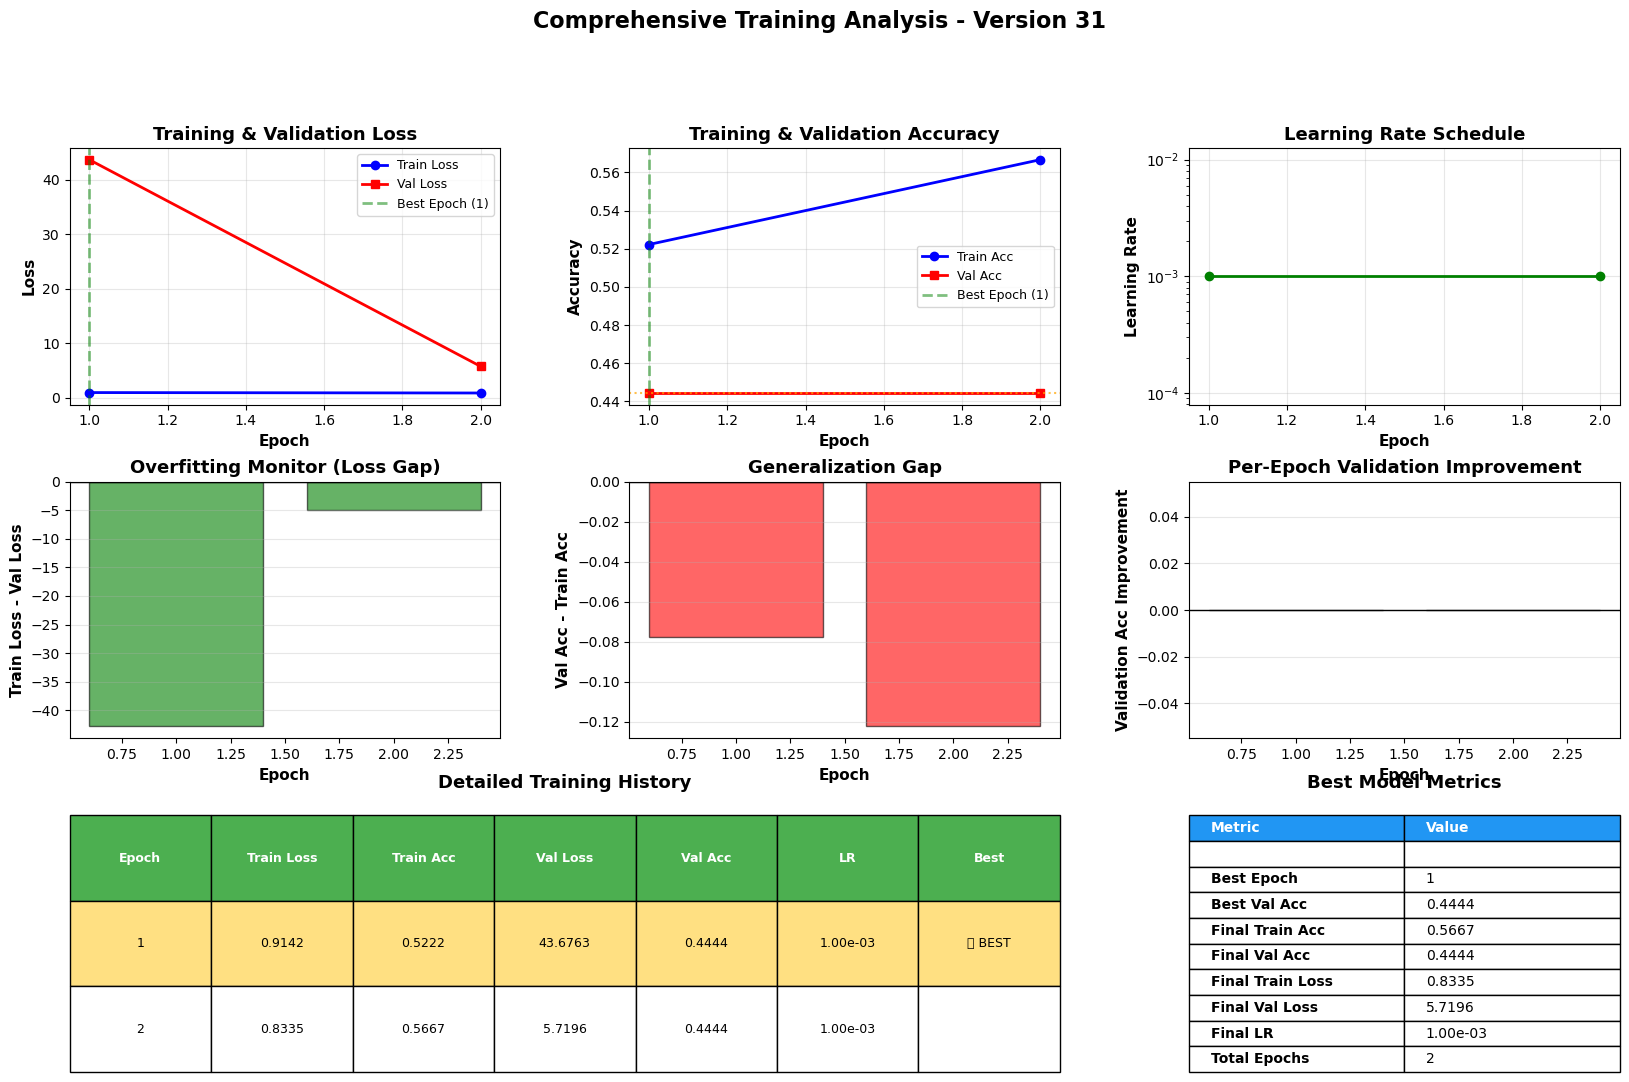

Comprehensive training analysis saved to: eğitim_sonuçları\real_fake_detection_csv\görseller\v31\comprehensive_training_analysis.png


In [53]:
# Cell 13.5: Comprehensive Training Visualization

fig = plt.figure(figsize=(20, 12))
gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)

# Check if best_epoch exists
has_best_epoch = 'best_epoch' in locals() or 'best_epoch' in globals()

# 1. Loss Curves (Top Left)
ax1 = fig.add_subplot(gs[0, 0])
epochs_plot = list(range(epoch_start_num, epoch_start_num + actual_epochs_trained))

# Debug: Print training data status
print("=" * 60)
print("DEBUG: Training Data Status")
print("=" * 60)
print(f"actual_epochs_trained = {actual_epochs_trained}")
print(f"len(history['train_loss']) = {len(history['train_loss'])}")
print(f"len(epochs_plot) = {len(epochs_plot)}")
print(f"epochs_plot = {epochs_plot}")
print(f"epoch_start_num = {epoch_start_num}")
print("=" * 60)

# Check if we have training data
has_training_data = len(epochs_plot) > 0 and len(history['train_loss']) > 0

if has_training_data:
    ax1.plot(epochs_plot, history['train_loss'], 'b-o', label='Train Loss', linewidth=2, markersize=6)
    ax1.plot(epochs_plot, history['val_loss'], 'r-s', label='Val Loss', linewidth=2, markersize=6)

    if has_best_epoch:
        ax1.axvline(x=best_epoch, color='green', linestyle='--', linewidth=2, alpha=0.5, label=f'Best Epoch ({best_epoch})')
    else:
        ax1.text(0.5, 0.95, 'No improvement', transform=ax1.transAxes,
                 fontsize=9, color='red', ha='center', va='top',
                 bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
else:
    ax1.text(0.5, 0.5, 'No training data available\nPlease run training first',
             transform=ax1.transAxes, fontsize=12, color='red', ha='center', va='center',
             fontweight='bold', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8, edgecolor='red', linewidth=2))

ax1.set_xlabel('Epoch', fontsize=11, fontweight='bold')
ax1.set_ylabel('Loss', fontsize=11, fontweight='bold')
ax1.set_title('Training & Validation Loss', fontsize=13, fontweight='bold')
ax1.legend(fontsize=9)
ax1.grid(True, alpha=0.3)

# 2. Accuracy Curves (Top Middle)
ax2 = fig.add_subplot(gs[0, 1])

if has_training_data:
    ax2.plot(epochs_plot, history['train_acc'], 'b-o', label='Train Acc', linewidth=2, markersize=6)
    ax2.plot(epochs_plot, history['val_acc'], 'r-s', label='Val Acc', linewidth=2, markersize=6)

    if has_best_epoch:
        ax2.axvline(x=best_epoch, color='green', linestyle='--', linewidth=2, alpha=0.5, label=f'Best Epoch ({best_epoch})')
        if 'best_val_acc' in locals() or 'best_val_acc' in globals():
            ax2.axhline(y=best_val_acc, color='orange', linestyle=':', linewidth=1.5, alpha=0.7)
    else:
        ax2.text(0.5, 0.95, 'No improvement', transform=ax2.transAxes,
                 fontsize=9, color='red', ha='center', va='top',
                 bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
else:
    ax2.text(0.5, 0.5, 'No training data available\nPlease run training first',
             transform=ax2.transAxes, fontsize=12, color='red', ha='center', va='center',
             fontweight='bold', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8, edgecolor='red', linewidth=2))

ax2.set_xlabel('Epoch', fontsize=11, fontweight='bold')
ax2.set_ylabel('Accuracy', fontsize=11, fontweight='bold')
ax2.set_title('Training & Validation Accuracy', fontsize=13, fontweight='bold')
ax2.legend(fontsize=9)
ax2.grid(True, alpha=0.3)

# 3. Learning Rate Schedule (Top Right)
ax3 = fig.add_subplot(gs[0, 2])

if has_training_data:
    ax3.plot(epochs_plot, history['lr'], 'g-o', linewidth=2, markersize=6)
    ax3.set_yscale('log')
else:
    ax3.text(0.5, 0.5, 'No training data available\nPlease run training first',
             transform=ax3.transAxes, fontsize=12, color='red', ha='center', va='center',
             fontweight='bold', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8, edgecolor='red', linewidth=2))

ax3.set_xlabel('Epoch', fontsize=11, fontweight='bold')
ax3.set_ylabel('Learning Rate', fontsize=11, fontweight='bold')
ax3.set_title('Learning Rate Schedule', fontsize=13, fontweight='bold')
ax3.grid(True, alpha=0.3)

# 4. Loss Gap (Train - Val) (Middle Left)
ax4 = fig.add_subplot(gs[1, 0])

if has_training_data:
    loss_gap = [t - v for t, v in zip(history['train_loss'], history['val_loss'])]
    colors = ['green' if gap < 0 else 'red' for gap in loss_gap]
    ax4.bar(epochs_plot, loss_gap, color=colors, alpha=0.6, edgecolor='black')
    ax4.axhline(y=0, color='black', linestyle='-', linewidth=1)
else:
    ax4.text(0.5, 0.5, 'No training data available\nPlease run training first',
             transform=ax4.transAxes, fontsize=12, color='red', ha='center', va='center',
             fontweight='bold', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8, edgecolor='red', linewidth=2))

ax4.set_xlabel('Epoch', fontsize=11, fontweight='bold')
ax4.set_ylabel('Train Loss - Val Loss', fontsize=11, fontweight='bold')
ax4.set_title('Overfitting Monitor (Loss Gap)', fontsize=13, fontweight='bold')
ax4.grid(True, alpha=0.3, axis='y')

# 5. Accuracy Gap (Val - Train) (Middle Middle)
ax5 = fig.add_subplot(gs[1, 1])

if has_training_data:
    acc_gap = [v - t for t, v in zip(history['train_acc'], history['val_acc'])]
    colors = ['green' if gap > 0 else 'red' for gap in acc_gap]
    ax5.bar(epochs_plot, acc_gap, color=colors, alpha=0.6, edgecolor='black')
    ax5.axhline(y=0, color='black', linestyle='-', linewidth=1)
else:
    ax5.text(0.5, 0.5, 'No training data available\nPlease run training first',
             transform=ax5.transAxes, fontsize=12, color='red', ha='center', va='center',
             fontweight='bold', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8, edgecolor='red', linewidth=2))

ax5.set_xlabel('Epoch', fontsize=11, fontweight='bold')
ax5.set_ylabel('Val Acc - Train Acc', fontsize=11, fontweight='bold')
ax5.set_title('Generalization Gap', fontsize=13, fontweight='bold')
ax5.grid(True, alpha=0.3, axis='y')

# 6. Epoch Improvement (Middle Right)
ax6 = fig.add_subplot(gs[1, 2])

if has_training_data:
    val_improvements = [0] + [history['val_acc'][i] - history['val_acc'][i-1] for i in range(1, len(history['val_acc']))]
    colors = ['green' if imp > 0 else 'red' for imp in val_improvements]
    ax6.bar(epochs_plot, val_improvements, color=colors, alpha=0.6, edgecolor='black')
    ax6.axhline(y=0, color='black', linestyle='-', linewidth=1)
else:
    ax6.text(0.5, 0.5, 'No training data available\nPlease run training first',
             transform=ax6.transAxes, fontsize=12, color='red', ha='center', va='center',
             fontweight='bold', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8, edgecolor='red', linewidth=2))

ax6.set_xlabel('Epoch', fontsize=11, fontweight='bold')
ax6.set_ylabel('Validation Acc Improvement', fontsize=11, fontweight='bold')
ax6.set_title('Per-Epoch Validation Improvement', fontsize=13, fontweight='bold')
ax6.grid(True, alpha=0.3, axis='y')

# 7. Training Progress Summary Table (Bottom Left)
ax7 = fig.add_subplot(gs[2, :2])
ax7.axis('off')

# Build summary data only if training data exists
summary_data = []
if has_training_data:
    for i, epoch in enumerate(epochs_plot):
        # Check best_epoch safely
        is_best = (epoch == best_epoch) if has_best_epoch else False

        summary_data.append([
            epoch,
            f"{history['train_loss'][i]:.4f}",
            f"{history['train_acc'][i]:.4f}",
            f"{history['val_loss'][i]:.4f}",
            f"{history['val_acc'][i]:.4f}",
            f"{history['lr'][i]:.2e}",
            "✅ BEST" if is_best else ""
        ])

# Check if summary_data is empty (no training data)
if not summary_data:
    # No training data - show message instead of empty table
    ax7.text(0.5, 0.5, 'Eğitim verisi yok / No training data\nPlease run training first',
             transform=ax7.transAxes, fontsize=14, color='red',
             ha='center', va='center', fontweight='bold',
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8, edgecolor='red', linewidth=2))
    ax7.set_title('Detailed Training History', fontsize=13, fontweight='bold', pad=20)
else:
    # Create table with training data
    table = ax7.table(cellText=summary_data,
                      colLabels=['Epoch', 'Train Loss', 'Train Acc', 'Val Loss', 'Val Acc', 'LR', 'Best'],
                      cellLoc='center',
                      loc='center',
                      bbox=[0, 0, 1, 1])
    table.auto_set_font_size(False)
    table.set_fontsize(9)
    table.scale(1, 2)

    # Style header
    for i in range(7):
        table[(0, i)].set_facecolor('#4CAF50')
        table[(0, i)].set_text_props(weight='bold', color='white')

    # Highlight best epoch row
    if has_best_epoch:
        for i, epoch in enumerate(epochs_plot):
            if epoch == best_epoch:
                for j in range(7):
                    table[(i+1, j)].set_facecolor('#FFE082')

    ax7.set_title('Detailed Training History', fontsize=13, fontweight='bold', pad=20)

# 8. Best Metrics Summary (Bottom Right)
ax8 = fig.add_subplot(gs[2, 2])
ax8.axis('off')

if has_training_data:
    best_metrics = [
        ['Metric', 'Value'],
        ['', ''],
        ['Best Epoch', f'{best_epoch}' if has_best_epoch else 'N/A'],
        ['Best Val Acc', f'{best_val_acc:.4f}' if ('best_val_acc' in locals() or 'best_val_acc' in globals()) else 'N/A'],
        ['Final Train Acc', f'{history["train_acc"][-1]:.4f}'],
        ['Final Val Acc', f'{history["val_acc"][-1]:.4f}'],
        ['Final Train Loss', f'{history["train_loss"][-1]:.4f}'],
        ['Final Val Loss', f'{history["val_loss"][-1]:.4f}'],
        ['Final LR', f'{history["lr"][-1]:.2e}'],
        ['Total Epochs', f'{actual_epochs_trained}']
    ]

    table2 = ax8.table(cellText=best_metrics,
                       cellLoc='left',
                       loc='center',
                       bbox=[0, 0, 1, 1])
    table2.auto_set_font_size(False)
    table2.set_fontsize(10)
    table2.scale(1, 2.5)

    # Style header
    table2[(0, 0)].set_facecolor('#2196F3')
    table2[(0, 0)].set_text_props(weight='bold', color='white')
    table2[(0, 1)].set_facecolor('#2196F3')
    table2[(0, 1)].set_text_props(weight='bold', color='white')

    # Bold metric names
    for i in range(2, len(best_metrics)):
        table2[(i, 0)].set_text_props(weight='bold')

    ax8.set_title('Best Model Metrics', fontsize=13, fontweight='bold', pad=20)
else:
    # No training data
    ax8.text(0.5, 0.5, 'Eğitim verisi yok / No training data\nPlease run training first',
             transform=ax8.transAxes, fontsize=14, color='red',
             ha='center', va='center', fontweight='bold',
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8, edgecolor='red', linewidth=2))
    ax8.set_title('Best Model Metrics', fontsize=13, fontweight='bold', pad=20)

plt.suptitle(f'Comprehensive Training Analysis - Version {version}',
             fontsize=16, fontweight='bold', y=0.995)

# Save
comprehensive_path = os.path.join(viz_dir, 'comprehensive_training_analysis.png')
plt.savefig(comprehensive_path, dpi=300, bbox_inches='tight')
plt.show()

print(f"Comprehensive training analysis saved to: {comprehensive_path}")


In [54]:
# Cell 14: Load Best Model and Run Test Inference

print("="*60)
print("TEST EVALUATION")
print("="*60)

# Load best model
best_model_path = os.path.join(models_dir, 'best_model.pth')

# Check if best_epoch exists before printing
if 'best_epoch' in locals() or 'best_epoch' in globals():
    print(f"\nLoading best model from epoch {best_epoch}")
else:
    print(f"\nLoading best model (no improvement was tracked during training)")

print(f"Path: {best_model_path}")

# Print best_val_acc if it exists
if 'best_val_acc' in locals() or 'best_val_acc' in globals():
    print(f"Best validation accuracy: {best_val_acc:.4f}")
else:
    print(f"Best validation accuracy: Not tracked")

checkpoint = torch.load(best_model_path)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

print("\nRunning test inference...")

# Storage for predictions and metadata
all_predictions = []
all_real_confidences = []  # Real class (0) confidence for ALL samples
all_fake_confidences = []  # Fake class (1) confidence for ALL samples
all_confidences = []  # Max confidence (existing)
all_labels = []
all_confidences = []
all_metadata = []

# Run inference
with torch.no_grad():
    test_pbar = tqdm(test_loader, desc="Test Inference", unit="batch")

    for images, labels, metadata_batch in test_pbar:
        images = images.to(device)

        # Forward pass
        outputs = model(images)
        probs = torch.softmax(outputs, dim=1)

        # Extract per-class confidences
        real_confs = probs[:, 0].cpu().numpy()
        fake_confs = probs[:, 1].cpu().numpy()
        confidences, predictions = torch.max(probs, dim=1)

        # Store results
        all_predictions.extend(predictions.cpu().numpy())
        all_labels.extend(labels.numpy())
        all_real_confidences.extend(real_confs)
        all_fake_confidences.extend(fake_confs)
        all_confidences.extend(confidences.cpu().numpy())
        all_metadata.extend(metadata_batch)

# Convert to numpy arrays
all_predictions = np.array(all_predictions)
all_labels = np.array(all_labels)
all_confidences = np.array(all_confidences)

# Calculate test accuracy
test_accuracy = accuracy_score(all_labels, all_predictions)

print(f"\n{'='*60}")
print(f"TEST RESULTS")
print(f"{'='*60}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Total test samples: {len(all_labels)}")
print(f"Correct predictions: {(all_predictions == all_labels).sum()}")
print(f"Incorrect predictions: {(all_predictions != all_labels).sum()}")
print(f"{'='*60}")


TEST EVALUATION

Loading best model from epoch 1
Path: eğitim_sonuçları\real_fake_detection_csv\models\best_model.pth
Best validation accuracy: 0.4444

Running test inference...


Test Inference: 100%|██████████| 2/2 [00:00<00:00,  4.02batch/s]


TEST RESULTS
Test Accuracy: 0.5000
Total test samples: 18
Correct predictions: 9
Incorrect predictions: 9


Running inference on Train and Val sets for comprehensive comparison...


Val Inference: 100%|██████████| 2/2 [00:00<00:00,  3.67it/s]


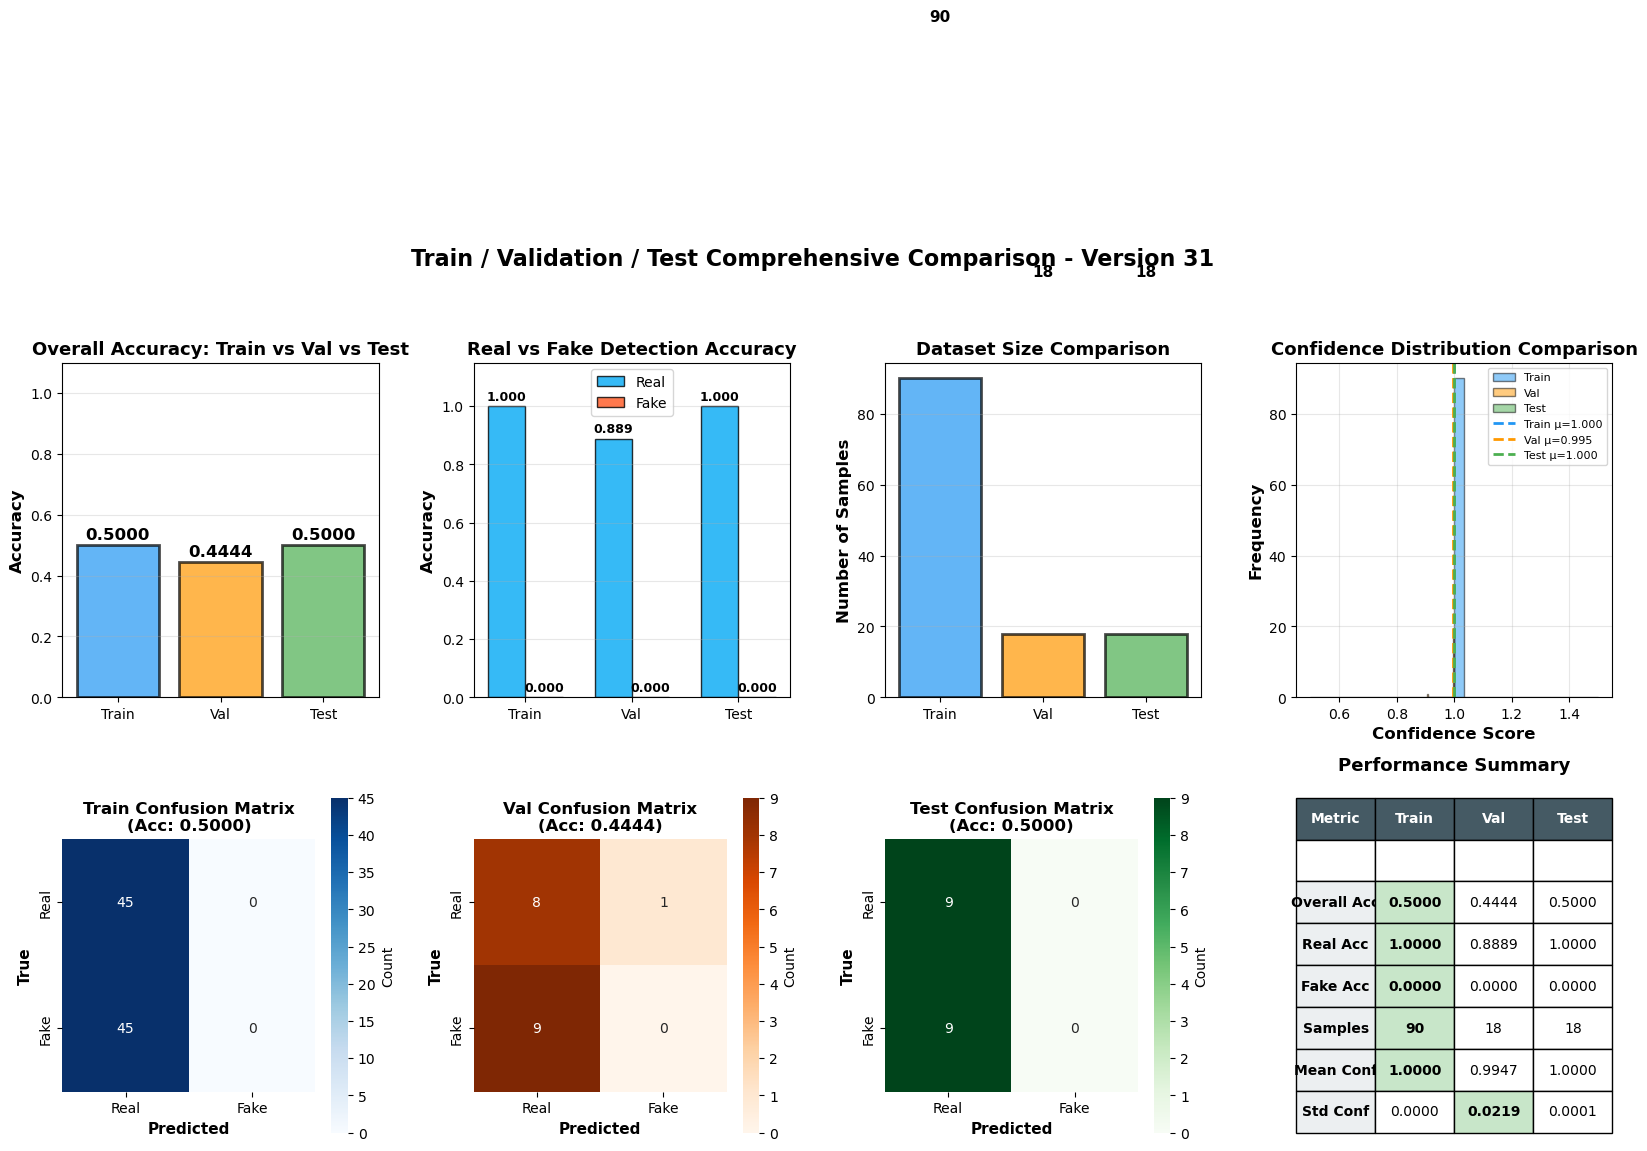


Train/Val/Test comparison saved to: eğitim_sonuçları\real_fake_detection_csv\görseller\v31\train_val_test_comparison.png

COMPREHENSIVE PERFORMANCE SUMMARY
Train Accuracy: 0.5000 (Real: 1.0000, Fake: 0.0000)
Val Accuracy:   0.4444 (Real: 0.8889, Fake: 0.0000)
Test Accuracy:  0.5000 (Real: 1.0000, Fake: 0.0000)


In [55]:
# Cell 14.5: Train/Val/Test Comprehensive Comparison

# First, we need to get train and val predictions for comparison
print("Running inference on Train and Val sets for comprehensive comparison...")

# Train set inference
model.eval()
train_preds = []
train_labels_list = []
train_real_confs = []
train_fake_confs = []
train_confs = []
train_confs = []

with torch.no_grad():
    for images, labels, _ in tqdm(train_loader, desc="Train Inference"):
        images = images.to(device)
        outputs = model(images)
        probs = torch.softmax(outputs, dim=1)
        confidences, predictions = torch.max(probs, dim=1)
        
        train_preds.extend(predictions.cpu().numpy())
        train_labels_list.extend(labels.numpy())
        train_confs.extend(confidences.cpu().numpy())

train_preds = np.array(train_preds)
train_labels_list = np.array(train_labels_list)
train_real_confs = np.array(train_real_confs)
train_fake_confs = np.array(train_fake_confs)
train_confs = np.array(train_confs)

# Val set inference  
val_preds = []
val_labels_list = []
val_real_confs = []
val_fake_confs = []
val_confs = []
val_confs = []

with torch.no_grad():
    for images, labels, _ in tqdm(val_loader, desc="Val Inference"):
        images = images.to(device)
        outputs = model(images)
        probs = torch.softmax(outputs, dim=1)
        confidences, predictions = torch.max(probs, dim=1)
        
        val_preds.extend(predictions.cpu().numpy())
        val_labels_list.extend(labels.numpy())
        val_confs.extend(confidences.cpu().numpy())

val_preds = np.array(val_preds)
val_labels_list = np.array(val_labels_list)
val_real_confs = np.array(val_real_confs)
val_fake_confs = np.array(val_fake_confs)
val_confs = np.array(val_confs)

# Calculate metrics
train_acc = accuracy_score(train_labels_list, train_preds)
val_acc = accuracy_score(val_labels_list, val_preds)

# Real/Fake breakdown
train_real_acc = (train_preds[train_labels_list == 0] == 0).mean()
train_fake_acc = (train_preds[train_labels_list == 1] == 1).mean()

val_real_acc = (val_preds[val_labels_list == 0] == 0).mean()
val_fake_acc = (val_preds[val_labels_list == 1] == 1).mean()

test_real_acc = (all_predictions[all_labels == 0] == 0).mean()
test_fake_acc = (all_predictions[all_labels == 1] == 1).mean()

# Create comprehensive comparison plot
fig = plt.figure(figsize=(20, 10))
gs = fig.add_gridspec(2, 4, hspace=0.3, wspace=0.3)

# 1. Overall Accuracy Comparison (Top Left)
ax1 = fig.add_subplot(gs[0, 0])
sets = ['Train', 'Val', 'Test']
accuracies = [train_acc, val_acc, test_accuracy]
colors = ['#2196F3', '#FF9800', '#4CAF50']
bars = ax1.bar(sets, accuracies, color=colors, alpha=0.7, edgecolor='black', linewidth=2)

for i, (bar, acc) in enumerate(zip(bars, accuracies)):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + 0.01,
             f'{acc:.4f}',
             ha='center', va='bottom', fontsize=12, fontweight='bold')

ax1.set_ylabel('Accuracy', fontsize=12, fontweight='bold')
ax1.set_title('Overall Accuracy: Train vs Val vs Test', fontsize=13, fontweight='bold')
ax1.set_ylim([0, 1.1])
ax1.grid(True, alpha=0.3, axis='y')

# 2. Real vs Fake Accuracy by Set (Top Middle-Left)
ax2 = fig.add_subplot(gs[0, 1])
x = np.arange(3)
width = 0.35

real_accs = [train_real_acc, val_real_acc, test_real_acc]
fake_accs = [train_fake_acc, val_fake_acc, test_fake_acc]

bars1 = ax2.bar(x - width/2, real_accs, width, label='Real', color='#03A9F4', alpha=0.8, edgecolor='black')
bars2 = ax2.bar(x + width/2, fake_accs, width, label='Fake', color='#FF5722', alpha=0.8, edgecolor='black')

# Add value labels
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                 f'{height:.3f}',
                 ha='center', va='bottom', fontsize=9, fontweight='bold')

ax2.set_ylabel('Accuracy', fontsize=12, fontweight='bold')
ax2.set_title('Real vs Fake Detection Accuracy', fontsize=13, fontweight='bold')
ax2.set_xticks(x)
ax2.set_xticklabels(sets)
ax2.legend(fontsize=10)
ax2.set_ylim([0, 1.15])
ax2.grid(True, alpha=0.3, axis='y')

# 3. Sample Count Comparison (Top Middle-Right)
ax3 = fig.add_subplot(gs[0, 2])
sample_counts = [len(train_labels_list), len(val_labels_list), len(all_labels)]
bars = ax3.bar(sets, sample_counts, color=colors, alpha=0.7, edgecolor='black', linewidth=2)

for bar, count in zip(bars, sample_counts):
    height = bar.get_height()
    ax3.text(bar.get_x() + bar.get_width()/2., height + 100,
             f'{count:,}',
             ha='center', va='bottom', fontsize=11, fontweight='bold')

ax3.set_ylabel('Number of Samples', fontsize=12, fontweight='bold')
ax3.set_title('Dataset Size Comparison', fontsize=13, fontweight='bold')
ax3.grid(True, alpha=0.3, axis='y')

# 4. Confidence Distribution Comparison (Top Right)
ax4 = fig.add_subplot(gs[0, 3])
ax4.hist(train_confs, bins=30, alpha=0.5, label='Train', color='#2196F3', edgecolor='black')
ax4.hist(val_confs, bins=30, alpha=0.5, label='Val', color='#FF9800', edgecolor='black')
ax4.hist(all_confidences, bins=30, alpha=0.5, label='Test', color='#4CAF50', edgecolor='black')

ax4.axvline(train_confs.mean(), color='#2196F3', linestyle='--', linewidth=2, label=f'Train μ={train_confs.mean():.3f}')
ax4.axvline(val_confs.mean(), color='#FF9800', linestyle='--', linewidth=2, label=f'Val μ={val_confs.mean():.3f}')
ax4.axvline(all_confidences.mean(), color='#4CAF50', linestyle='--', linewidth=2, label=f'Test μ={all_confidences.mean():.3f}')

ax4.set_xlabel('Confidence Score', fontsize=12, fontweight='bold')
ax4.set_ylabel('Frequency', fontsize=12, fontweight='bold')
ax4.set_title('Confidence Distribution Comparison', fontsize=13, fontweight='bold')
ax4.legend(fontsize=8)
ax4.grid(True, alpha=0.3)

# 5. Confusion Matrices Side by Side (Bottom)
# Train CM
ax5 = fig.add_subplot(gs[1, 0])
train_cm = confusion_matrix(train_labels_list, train_preds)
sns.heatmap(train_cm, annot=True, fmt='d', cmap='Blues', ax=ax5,
            xticklabels=['Real', 'Fake'], yticklabels=['Real', 'Fake'],
            cbar_kws={'label': 'Count'}, square=True)
ax5.set_title(f'Train Confusion Matrix\n(Acc: {train_acc:.4f})', fontsize=12, fontweight='bold')
ax5.set_xlabel('Predicted', fontsize=11, fontweight='bold')
ax5.set_ylabel('True', fontsize=11, fontweight='bold')

# Val CM
ax6 = fig.add_subplot(gs[1, 1])
val_cm = confusion_matrix(val_labels_list, val_preds)
sns.heatmap(val_cm, annot=True, fmt='d', cmap='Oranges', ax=ax6,
            xticklabels=['Real', 'Fake'], yticklabels=['Real', 'Fake'],
            cbar_kws={'label': 'Count'}, square=True)
ax6.set_title(f'Val Confusion Matrix\n(Acc: {val_acc:.4f})', fontsize=12, fontweight='bold')
ax6.set_xlabel('Predicted', fontsize=11, fontweight='bold')
ax6.set_ylabel('True', fontsize=11, fontweight='bold')

# Test CM
ax7 = fig.add_subplot(gs[1, 2])
test_cm = confusion_matrix(all_labels, all_predictions)
sns.heatmap(test_cm, annot=True, fmt='d', cmap='Greens', ax=ax7,
            xticklabels=['Real', 'Fake'], yticklabels=['Real', 'Fake'],
            cbar_kws={'label': 'Count'}, square=True)
ax7.set_title(f'Test Confusion Matrix\n(Acc: {test_accuracy:.4f})', fontsize=12, fontweight='bold')
ax7.set_xlabel('Predicted', fontsize=11, fontweight='bold')
ax7.set_ylabel('True', fontsize=11, fontweight='bold')

# 6. Summary Statistics Table (Bottom Right)
ax8 = fig.add_subplot(gs[1, 3])
ax8.axis('off')

summary_stats = [
    ['Metric', 'Train', 'Val', 'Test'],
    ['', '', '', ''],
    ['Overall Acc', f'{train_acc:.4f}', f'{val_acc:.4f}', f'{test_accuracy:.4f}'],
    ['Real Acc', f'{train_real_acc:.4f}', f'{val_real_acc:.4f}', f'{test_real_acc:.4f}'],
    ['Fake Acc', f'{train_fake_acc:.4f}', f'{val_fake_acc:.4f}', f'{test_fake_acc:.4f}'],
    ['Samples', f'{len(train_labels_list):,}', f'{len(val_labels_list):,}', f'{len(all_labels):,}'],
    ['Mean Conf', f'{train_confs.mean():.4f}', f'{val_confs.mean():.4f}', f'{all_confidences.mean():.4f}'],
    ['Std Conf', f'{train_confs.std():.4f}', f'{val_confs.std():.4f}', f'{all_confidences.std():.4f}']
]

table = ax8.table(cellText=summary_stats,
                  cellLoc='center',
                  loc='center',
                  bbox=[0, 0, 1, 1])
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1, 2.5)

# Style header row
for i in range(4):
    table[(0, i)].set_facecolor('#455A64')
    table[(0, i)].set_text_props(weight='bold', color='white')

# Style metric names
for i in range(2, len(summary_stats)):
    table[(i, 0)].set_facecolor('#ECEFF1')
    table[(i, 0)].set_text_props(weight='bold')

# Highlight best values in each row
for i in range(2, len(summary_stats)):
    values = [float(summary_stats[i][j].replace(',', '')) for j in range(1, 4)]
    best_idx = values.index(max(values))
    table[(i, best_idx + 1)].set_facecolor('#C8E6C9')
    table[(i, best_idx + 1)].set_text_props(weight='bold')

ax8.set_title('Performance Summary', fontsize=13, fontweight='bold', pad=20)

plt.suptitle(f'Train / Validation / Test Comprehensive Comparison - Version {version}', 
             fontsize=16, fontweight='bold', y=0.995)

# Save
comparison_path = os.path.join(viz_dir, 'train_val_test_comparison.png')
plt.savefig(comparison_path, dpi=300, bbox_inches='tight')
plt.show()

print(f"\nTrain/Val/Test comparison saved to: {comparison_path}")
print(f"\n{'='*60}")
print("COMPREHENSIVE PERFORMANCE SUMMARY")
print(f"{'='*60}")
print(f"Train Accuracy: {train_acc:.4f} (Real: {train_real_acc:.4f}, Fake: {train_fake_acc:.4f})")
print(f"Val Accuracy:   {val_acc:.4f} (Real: {val_real_acc:.4f}, Fake: {val_fake_acc:.4f})")
print(f"Test Accuracy:  {test_accuracy:.4f} (Real: {test_real_acc:.4f}, Fake: {test_fake_acc:.4f})")
print(f"{'='*60}")

In [56]:
# Cell 15: Build Comprehensive Results DataFrame

# Check if test results are available
if not ('all_labels' in locals() or 'all_labels' in globals()) or not ('all_predictions' in locals() or 'all_predictions' in globals()):
    print("="*60)
    print("TEST SONUÇLARI YOK / NO TEST RESULTS")
    print("="*60)
    print("Please run test evaluation first (Cell 14)")
    print("Önce test değerlendirmesini çalıştırın (Hücre 14)")
else:
    print("Building comprehensive results DataFrame...")
    
    # Create base results
    results_data = {
        'true_label': ['real' if label == 0 else 'fake' for label in all_labels],
        'predicted_label': ['real' if pred == 0 else 'fake' for pred in all_predictions],
        'confidence': all_confidences,
        'confidence_real': all_real_confidences,  # YENİ
        'confidence_fake': all_fake_confidences,  # YENİ
        'correct': (all_predictions == all_labels).astype(int)
    }
    
    # Add metadata fields
    # We need to extract metadata from the list of dicts
    for key in ['label_name', 'perturbed_img_id', 'real_img_id', 'mask_name', 'domain', 
                'ssim', 'lpips_score', 'mse', 'model_name', 'dataset', 'area_ratio', 
                'sem_magnitude', 'parent_dataset']:
        results_data[key] = [metadata.get(key, None) for metadata in all_metadata]
    
    
# DEBUG: Check array lengths before creating DataFrame
print("Array lengths:")
print(f"  all_labels: {len(all_labels)}")
print(f"  all_predictions: {len(all_predictions)}")
print(f"  all_confidences: {len(all_confidences)}")
print(f"  all_real_confidences: {len(all_real_confidences)}")
print(f"  all_fake_confidences: {len(all_fake_confidences)}")
print(f"  all_metadata: {len(all_metadata)}")

# Check results_data keys
for key in results_data:
    print(f"  {key}: {len(results_data[key])}")
    print()
# Create DataFrame
    results_df = pd.DataFrame(results_data)
    
    print(f"Results DataFrame shape: {results_df.shape}")
    print(f"First few rows:")
    print(results_df.head())
    
    print(f"Class distribution:")
    print(results_df['true_label'].value_counts())
    
    print(f"Prediction distribution:")
    print(results_df['predicted_label'].value_counts())
    
    print(f"Accuracy by true label:")
    print(results_df.groupby('true_label')['correct'].mean())


Building comprehensive results DataFrame...
Array lengths:
  all_labels: 18
  all_predictions: 18
  all_confidences: 18
  all_real_confidences: 18
  all_fake_confidences: 18
  all_metadata: 18
  true_label: 18

Results DataFrame shape: (18, 19)
First few rows:
  true_label predicted_label  confidence  confidence_real  confidence_fake  \
0       fake            real         1.0              1.0     2.003857e-43   
1       fake            real         1.0              1.0     1.420552e-40   
2       fake            real         1.0              1.0     0.000000e+00   
3       fake            real         1.0              1.0     1.897471e-38   
4       fake            real         1.0              1.0     0.000000e+00   

   correct label_name                                   perturbed_img_id  \
0        0       fake  instance_003_ADE_train_00013601_ADE20K_StableD...   
1        0       fake  zurich_000077_000019_instance013_CityScapes_Ka...   
2        0       fake  instance_001_ADE_tr

In [57]:
# Cell 16: Export Misclassified Fake Images

# Check if test results are available
if not ('results_df' in locals() or 'results_df' in globals()):
    print("="*60)
    print("TEST SONUÇLARI YOK / NO TEST RESULTS")
    print("="*60)
    print("\nPlease run test evaluation first (Cell 14-16)")
    print("Önce test değerlendirmesini çalıştırın (Hücre 14-16)\n")
else:
    print("="*60)
    print("MISCLASSIFIED FAKE IMAGES ANALYSIS")
    print("="*60)
    
    # Filter for misclassified fake images (true=fake, predicted=real)
    misclassified_fake = results_df[
        (results_df['true_label'] == 'fake') & 
        (results_df['predicted_label'] == 'real')
    ].copy()
    
    print(f"\nTotal fake images: {(results_df['true_label'] == 'fake').sum()}")
    print(f"Correctly classified fake: {((results_df['true_label'] == 'fake') & (results_df['correct'] == 1)).sum()}")
    print(f"Misclassified fake (predicted as real): {len(misclassified_fake)}")
    print(f"Fake detection accuracy: {((results_df['true_label'] == 'fake') & (results_df['correct'] == 1)).sum() / (results_df['true_label'] == 'fake').sum():.4f}")
    
    # Select relevant columns for export
    export_columns = ['perturbed_img_id', 'real_img_id', 'confidence', 'mask_name', 'domain', 
                      'ssim', 'lpips_score', 'mse', 'model_name', 'dataset', 
                      'area_ratio', 'sem_magnitude']
    
    misclassified_export = misclassified_fake[export_columns].copy()
    
    # Save to CSV
    misclassified_path = os.path.join(data_dir, 'misclassified_fake_images.csv')
    misclassified_export.to_csv(misclassified_path, index=False)
    
    print(f"\nMisclassified fake images saved to: {misclassified_path}")
    print(f"Total rows exported: {len(misclassified_export)}")
    
    # Show sample of misclassified images
    if len(misclassified_fake) > 0:
        print(f"\nSample of misclassified fake images:")
        print(misclassified_export.head(10))


MISCLASSIFIED FAKE IMAGES ANALYSIS

Total fake images: 9
Correctly classified fake: 0
Misclassified fake (predicted as real): 9
Fake detection accuracy: 0.0000

Misclassified fake images saved to: eğitim_sonuçları\real_fake_detection_csv\veriler\v31\misclassified_fake_images.csv
Total rows exported: 9

Sample of misclassified fake images:
                                    perturbed_img_id  \
0  instance_003_ADE_train_00013601_ADE20K_StableD...   
1  zurich_000077_000019_instance013_CityScapes_Ka...   
2  instance_001_ADE_train_00004657_ADE20K_StableD...   
3    img_04702_Upperclothes_HumanParsing_OpenJourney   
4  instance_009_ADE_train_00011070_ADE20K_StableD...   
5  instance_013_ADE_train_00009856_ADE20K_StableD...   
6         img_05438_Leftarm_HumanParsing_OpenJourney   
7  instance_022_ADE_train_00014385_ADE20K_StableD...   
8                 01719_l_ear_CelebAHQ_Kandinsky_2_2   

                        real_img_id  confidence      mask_name      domain  \
0                ADE

IndexError: index 0 is out of bounds for axis 0 with size 0

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


<Figure size 2000x1200 with 0 Axes>

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


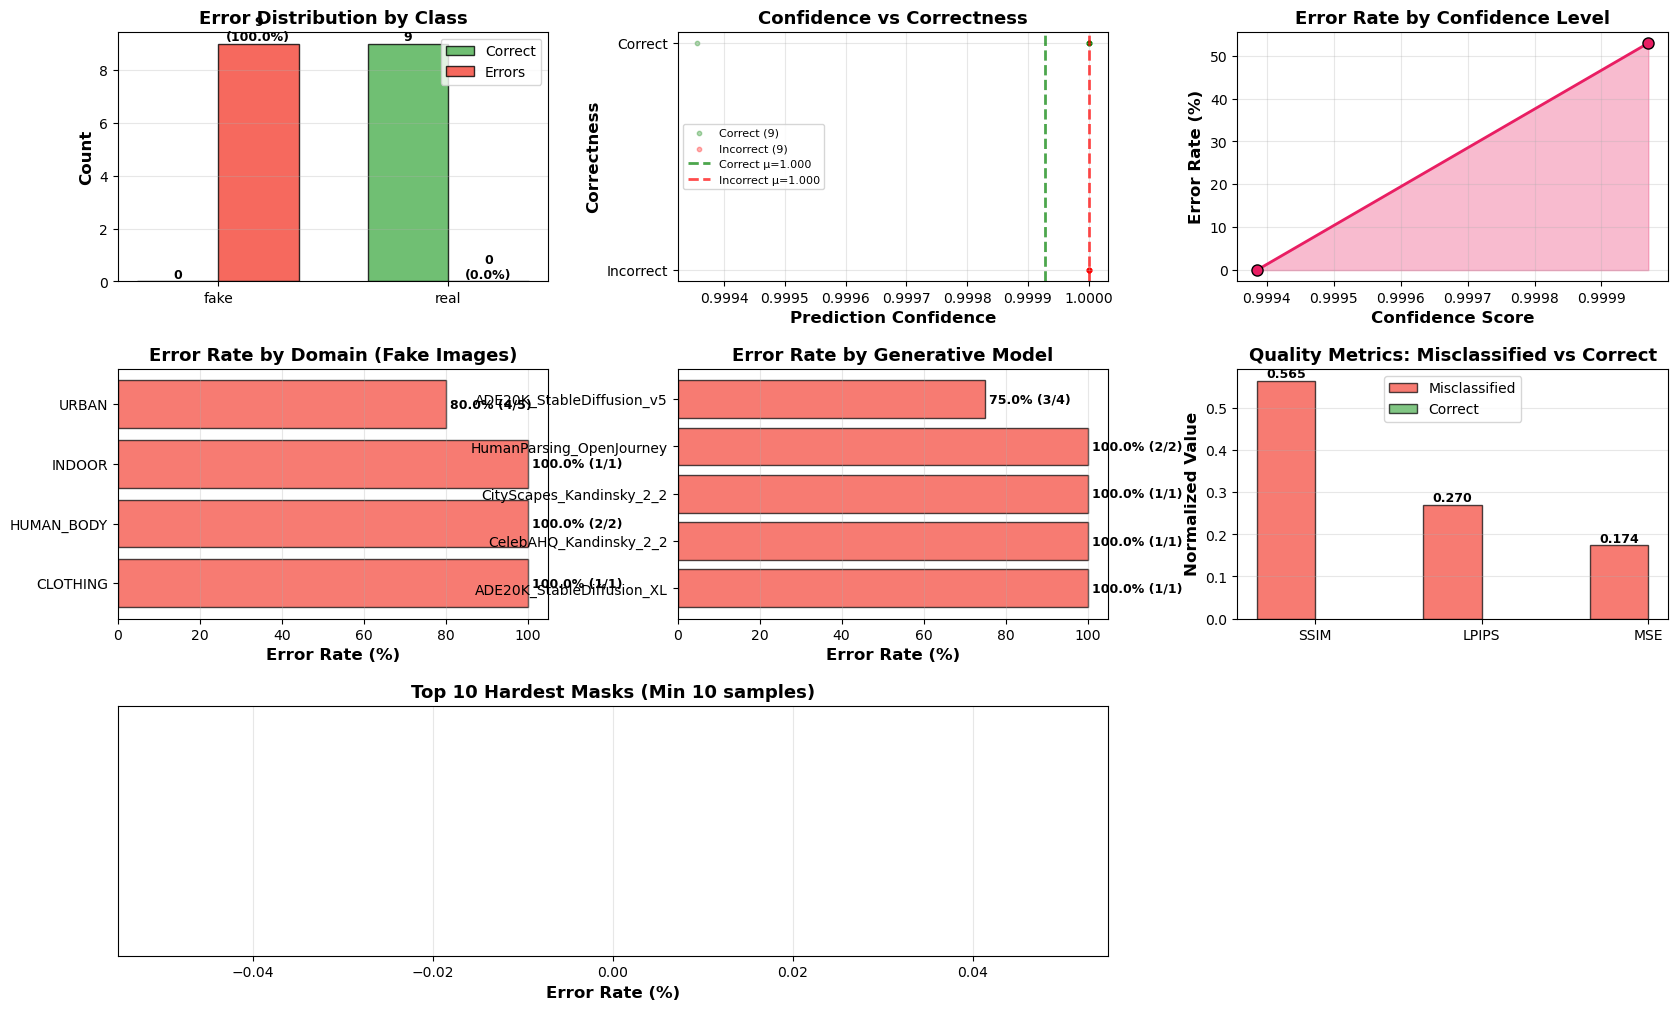

In [58]:
# Cell 17.5: Comprehensive Error Analysis Visualization

# Check if test results are available
if not ('fake_results' in locals() or 'fake_results' in globals()) or not ('results_df' in locals() or 'results_df' in globals()):
    print("="*60)
    print("TEST SONUÇLARI YOK / NO TEST RESULTS")
    print("="*60)
    print("Please run test evaluation first (Cell 14-16)")
    print("Önce test değerlendirmesini çalıştırın (Hücre 14-16)")
else:
    fig = plt.figure(figsize=(20, 12))
    fig = plt.figure(figsize=(20, 12))
    gs = fig.add_gridspec(3, 3, hspace=0.35, wspace=0.3)
    
    # 1. Error Distribution by Class (Top Left)
    ax1 = fig.add_subplot(gs[0, 0])
    error_data = results_df.groupby('true_label')['correct'].agg(['count', 'sum'])
    error_data['errors'] = error_data['count'] - error_data['sum']
    error_data['error_rate'] = error_data['errors'] / error_data['count']
    
    x = np.arange(len(error_data))
    width = 0.35
    
    bars1 = ax1.bar(x - width/2, error_data['sum'], width, label='Correct', color='#4CAF50', alpha=0.8, edgecolor='black')
    bars2 = ax1.bar(x + width/2, error_data['errors'], width, label='Errors', color='#F44336', alpha=0.8, edgecolor='black')
    
    # Add values on bars
    for bar in bars1:
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height,
                 f'{int(height):,}',
                 ha='center', va='bottom', fontsize=9, fontweight='bold')
    
    for bar, error_rate in zip(bars2, error_data['error_rate']):
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height,
                 f'{int(height):,}\n({error_rate*100:.1f}%)',
                 ha='center', va='bottom', fontsize=9, fontweight='bold')
    
    ax1.set_ylabel('Count', fontsize=12, fontweight='bold')
    ax1.set_title('Error Distribution by Class', fontsize=13, fontweight='bold')
    ax1.set_xticks(x)
    ax1.set_xticklabels(error_data.index)
    ax1.legend(fontsize=10)
    ax1.grid(True, alpha=0.3, axis='y')
    
    # 2. Confidence vs Correctness (Top Middle)
    ax2 = fig.add_subplot(gs[0, 1])
    correct_mask = results_df['correct'] == 1
    incorrect_mask = results_df['correct'] == 0
    
    ax2.scatter(results_df[correct_mask]['confidence'], [1]*correct_mask.sum(), 
               alpha=0.3, s=10, color='green', label=f'Correct ({correct_mask.sum():,})')
    ax2.scatter(results_df[incorrect_mask]['confidence'], [0]*incorrect_mask.sum(), 
               alpha=0.3, s=10, color='red', label=f'Incorrect ({incorrect_mask.sum():,})')
    
    ax2.axvline(results_df[correct_mask]['confidence'].mean(), color='green', 
               linestyle='--', linewidth=2, alpha=0.7, label=f'Correct μ={results_df[correct_mask]["confidence"].mean():.3f}')
    ax2.axvline(results_df[incorrect_mask]['confidence'].mean(), color='red', 
               linestyle='--', linewidth=2, alpha=0.7, label=f'Incorrect μ={results_df[incorrect_mask]["confidence"].mean():.3f}')
    
    ax2.set_xlabel('Prediction Confidence', fontsize=12, fontweight='bold')
    ax2.set_ylabel('Correctness', fontsize=12, fontweight='bold')
    ax2.set_yticks([0, 1])
    ax2.set_yticklabels(['Incorrect', 'Correct'])
    ax2.set_title('Confidence vs Correctness', fontsize=13, fontweight='bold')
    ax2.legend(fontsize=8, loc='center left')
    ax2.grid(True, alpha=0.3)
    
    # 3. Error Rate by Confidence Bins (Top Right)
    ax3 = fig.add_subplot(gs[0, 2])
    conf_bins = pd.cut(results_df['confidence'], bins=10)
    error_by_conf = results_df.groupby(conf_bins)['correct'].agg(['count', 'sum'])
    error_by_conf['error_rate'] = 1 - (error_by_conf['sum'] / error_by_conf['count'])
    error_by_conf = error_by_conf.dropna()
    
    bin_centers = [interval.mid for interval in error_by_conf.index]
    ax3.plot(bin_centers, error_by_conf['error_rate'] * 100, 'o-', linewidth=2, 
            markersize=8, color='#E91E63', markeredgecolor='black', markeredgewidth=1)
    ax3.fill_between(bin_centers, 0, error_by_conf['error_rate'] * 100, alpha=0.3, color='#E91E63')
    
    ax3.set_xlabel('Confidence Score', fontsize=12, fontweight='bold')
    ax3.set_ylabel('Error Rate (%)', fontsize=12, fontweight='bold')
    ax3.set_title('Error Rate by Confidence Level', fontsize=13, fontweight='bold')
    ax3.grid(True, alpha=0.3)
    
    # 4. Domain Error Analysis (Middle Left)
    ax4 = fig.add_subplot(gs[1, 0])
    domain_errors = fake_results.groupby('domain')['correct'].agg(['count', 'sum'])
    domain_errors['errors'] = domain_errors['count'] - domain_errors['sum']
    domain_errors['error_rate'] = domain_errors['errors'] / domain_errors['count']
    domain_errors = domain_errors.sort_values('error_rate', ascending=False)
    
    colors_domain = ['#F44336' if rate > 0.3 else '#FF9800' if rate > 0.15 else '#4CAF50' 
                    for rate in domain_errors['error_rate']]
    
    bars = ax4.barh(range(len(domain_errors)), domain_errors['error_rate'] * 100, 
                   color=colors_domain, alpha=0.7, edgecolor='black')
    
    for i, (idx, row) in enumerate(domain_errors.iterrows()):
        ax4.text(row['error_rate'] * 100 + 1, i, 
                f"{row['error_rate']*100:.1f}% ({int(row['errors'])}/{int(row['count'])})",
                va='center', fontsize=9, fontweight='bold')
    
    ax4.set_yticks(range(len(domain_errors)))
    ax4.set_yticklabels(domain_errors.index)
    ax4.set_xlabel('Error Rate (%)', fontsize=12, fontweight='bold')
    ax4.set_title('Error Rate by Domain (Fake Images)', fontsize=13, fontweight='bold')
    ax4.grid(True, alpha=0.3, axis='x')
    
    # 5. Generative Model Error Analysis (Middle Middle)
    ax5 = fig.add_subplot(gs[1, 1])
    model_errors = fake_results.groupby('dataset')['correct'].agg(['count', 'sum'])
    model_errors['errors'] = model_errors['count'] - model_errors['sum']
    model_errors['error_rate'] = model_errors['errors'] / model_errors['count']
    model_errors = model_errors.sort_values('error_rate', ascending=False)
    
    colors_model = ['#F44336' if rate > 0.3 else '#FF9800' if rate > 0.15 else '#4CAF50' 
                   for rate in model_errors['error_rate']]
    
    bars = ax5.barh(range(len(model_errors)), model_errors['error_rate'] * 100, 
                   color=colors_model, alpha=0.7, edgecolor='black')
    
    for i, (idx, row) in enumerate(model_errors.iterrows()):
        ax5.text(row['error_rate'] * 100 + 1, i, 
                f"{row['error_rate']*100:.1f}% ({int(row['errors'])}/{int(row['count'])})",
                va='center', fontsize=9, fontweight='bold')
    
    ax5.set_yticks(range(len(model_errors)))
    ax5.set_yticklabels(model_errors.index)
    ax5.set_xlabel('Error Rate (%)', fontsize=12, fontweight='bold')
    ax5.set_title('Error Rate by Generative Model', fontsize=13, fontweight='bold')
    ax5.grid(True, alpha=0.3, axis='x')
    
    # 6. Quality Metrics for Misclassified vs Correct (Middle Right)
    ax6 = fig.add_subplot(gs[1, 2])
    
    metrics_to_plot = ['ssim', 'lpips_score', 'mse']
    metric_labels = ['SSIM', 'LPIPS', 'MSE']
    
    misclass_fake = fake_results[fake_results['correct'] == 0]
    correct_fake = fake_results[fake_results['correct'] == 1]
    
    x_pos = np.arange(len(metrics_to_plot))
    width = 0.35
    
    # Normalize metrics to 0-1 range for comparison
    def normalize(series):
        return (series - series.min()) / (series.max() - series.min())
    
    misclass_means = [normalize(misclass_fake[m].dropna()).mean() for m in metrics_to_plot]
    correct_means = [normalize(correct_fake[m].dropna()).mean() for m in metrics_to_plot]
    
    bars1 = ax6.bar(x_pos - width/2, misclass_means, width, label='Misclassified', 
                   color='#F44336', alpha=0.7, edgecolor='black')
    bars2 = ax6.bar(x_pos + width/2, correct_means, width, label='Correct', 
                   color='#4CAF50', alpha=0.7, edgecolor='black')
    
    # Add values
    for bars in [bars1, bars2]:
        for bar in bars:
            height = bar.get_height()
            ax6.text(bar.get_x() + bar.get_width()/2., height,
                    f'{height:.3f}',
                    ha='center', va='bottom', fontsize=9, fontweight='bold')
    
    ax6.set_ylabel('Normalized Value', fontsize=12, fontweight='bold')
    ax6.set_title('Quality Metrics: Misclassified vs Correct', fontsize=13, fontweight='bold')
    ax6.set_xticks(x_pos)
    ax6.set_xticklabels(metric_labels)
    ax6.legend(fontsize=10)
    ax6.grid(True, alpha=0.3, axis='y')
    
    # 7. Top 10 Hardest Masks (Bottom Left)
    ax7 = fig.add_subplot(gs[2, :2])
    mask_errors = fake_results.groupby('mask_name')['correct'].agg(['count', 'sum'])
    mask_errors = mask_errors[mask_errors['count'] >= 10]  # At least 10 samples
    mask_errors['errors'] = mask_errors['count'] - mask_errors['sum']
    mask_errors['error_rate'] = mask_errors['errors'] / mask_errors['count']
    hardest_masks = mask_errors.nlargest(10, 'error_rate')
    
    colors_mask = ['#F44336' if rate > 0.5 else '#FF9800' if rate > 0.3 else '#FFC107' 
                  for rate in hardest_masks['error_rate']]
    
    bars = ax7.barh(range(len(hardest_masks)), hardest_masks['error_rate'] * 100,
                   color=colors_mask, alpha=0.7, edgecolor='black')
    
    for i, (idx, row) in enumerate(hardest_masks.iterrows()):
        ax7.text(row['error_rate'] * 100 + 1, i, 
                f"{row['error_rate']*100:.1f}% ({int(row['errors'])}/{int(row['count'])})",
                va='center', fontsize=9, fontweight='bold')
    
    ax7.set_yticks(range(len(hardest_masks)))
    ax7.set_yticklabels([idx[:30] for idx in hardest_masks.index], fontsize=9)
    ax7.set_xlabel('Error Rate (%)', fontsize=12, fontweight='bold')
    ax7.set_title('Top 10 Hardest Masks (Min 10 samples)', fontsize=13, fontweight='bold')
    ax7.grid(True, alpha=0.3, axis='x')
    
    # 8. Error Summary Statistics (Bottom Right)
    ax8 = fig.add_subplot(gs[2, 2])
    ax8.axis('off')
    
    total_errors = (results_df['correct'] == 0).sum()
    real_errors = ((results_df['true_label'] == 'real') & (results_df['correct'] == 0)).sum()
    fake_errors = ((results_df['true_label'] == 'fake') & (results_df['correct'] == 0)).sum()
    
    error_stats = [
        ['Error Type', 'Count', '%'],
        ['', '', ''],
        ['Total Errors', f'{total_errors:,}', f'{total_errors/len(results_df)*100:.2f}%'],
        ['Real → Fake', f'{real_errors:,}', f'{real_errors/len(results_df)*100:.2f}%'],
        ['Fake → Real', f'{fake_errors:,}', f'{fake_errors/len(results_df)*100:.2f}%'],
        ['', '', ''],
        ['Hardest Domain', hardest_masks.index[0][:15], f'{hardest_masks.iloc[0]["error_rate"]*100:.1f}%'],
        ['Hardest Model', model_errors.index[0][:15], f'{model_errors.iloc[0]["error_rate"]*100:.1f}%'],
        ['', '', ''],
        ['Avg Confidence', '', ''],
        ['  Correct', f'{results_df[correct_mask]["confidence"].mean():.4f}', ''],
        ['  Incorrect', f'{results_df[incorrect_mask]["confidence"].mean():.4f}', ''],
    ]
    
    table = ax8.table(cellText=error_stats,
                      cellLoc='left',
                      loc='center',
                      bbox=[0, 0, 1, 1])
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1, 2)
    
    # Style header
    for i in range(3):
        table[(0, i)].set_facecolor('#D32F2F')
        table[(0, i)].set_text_props(weight='bold', color='white')
    
    # Highlight important rows
    for i in [2, 3, 4]:
        table[(i, 0)].set_facecolor('#FFEBEE')
        table[(i, 0)].set_text_props(weight='bold')
    
    ax8.set_title('Error Summary', fontsize=13, fontweight='bold', pad=20)
    
    plt.suptitle(f'Comprehensive Error Analysis - Version {version}', 
                 fontsize=16, fontweight='bold', y=0.995)
    
    # Save
    error_analysis_path = os.path.join(viz_dir, 'comprehensive_error_analysis.png')
    plt.savefig(error_analysis_path, dpi=300, bbox_inches='tight')
    plt.show()
    
    print(f"Comprehensive error analysis saved to: {error_analysis_path}")
    print(f"\n{'='*60}")
    print("ERROR ANALYSIS SUMMARY")
    print(f"{'='*60}")
    print(f"Total Errors: {total_errors:,} ({total_errors/len(results_df)*100:.2f}%)")
    print(f"  Real misclassified as Fake: {real_errors:,}")
    print(f"  Fake misclassified as Real: {fake_errors:,}")
    print(f"\nHardest Domain: {domain_errors.index[0]} (Error Rate: {domain_errors.iloc[0]['error_rate']*100:.2f}%)")
    print(f"Hardest Model: {model_errors.index[0]} (Error Rate: {model_errors.iloc[0]['error_rate']*100:.2f}%)")
    print(f"{'='*60}")


In [ ]:
# Cell 17: Domain/Mask/Model Accuracy Analysis

# Check if test results are available
if not ('results_df' in locals() or 'results_df' in globals()):
    print("="*60)
    print("TEST SONUÇLARI YOK / NO TEST RESULTS")
    print("="*60)
    print("Please run test evaluation first (Cell 14-16)")
    print("Önce test değerlendirmesini çalıştırın (Hücre 14-16)")
else:
    print("="*60)
    print("DETAILED ACCURACY ANALYSIS")
    print("="*60)
    
    # Filter for fake images only
    fake_results = results_df[results_df['true_label'] == 'fake'].copy()
    
    # 1. Domain-wise accuracy
    print("1. DOMAIN-WISE ACCURACY:")
    print("-" * 60)
    domain_accuracy = fake_results.groupby('domain')['correct'].agg([
        ('total_images', 'count'),
        ('correct_predictions', 'sum'),
        ('accuracy', 'mean')
    ]).sort_values('accuracy', ascending=False)
    
    print(domain_accuracy)
    
    # Save to CSV
    domain_path = os.path.join(data_dir, 'domain_accuracy.csv')
    domain_accuracy.to_csv(domain_path)
    print(f"Domain accuracy saved to: {domain_path}")
    
    # 2. Mask-wise accuracy
    print("2. MASK-WISE ACCURACY (Top 20):")
    print("-" * 60)
    mask_accuracy = fake_results.groupby('mask_name')['correct'].agg([
        ('total_images', 'count'),
        ('correct_predictions', 'sum'),
        ('accuracy', 'mean')
    ]).sort_values('accuracy', ascending=False)
    
    print(mask_accuracy.head(20))
    
    # Save to CSV
    mask_path = os.path.join(data_dir, 'mask_accuracy.csv')
    mask_accuracy.to_csv(mask_path)
    print(f"Mask accuracy saved to: {mask_path}")
    
    # 3. Generative model accuracy
    print("3. GENERATIVE MODEL ACCURACY:")
    print("-" * 60)
    model_accuracy = fake_results.groupby('dataset')['correct'].agg([
        ('total_images', 'count'),
        ('correct_predictions', 'sum'),
        ('accuracy', 'mean')
    ]).sort_values('accuracy', ascending=False)
    
    print(model_accuracy)
    
    # Save to CSV
    model_path = os.path.join(data_dir, 'generative_model_accuracy.csv')
    model_accuracy.to_csv(model_path)
    print(f"Generative model accuracy saved to: {model_path}")
    
    print("" + "="*60)


In [ ]:
# Cell 18: Standard Metrics (Confusion Matrix, Classification Report)

# Check if test results are available
if not ('all_labels' in locals() or 'all_labels' in globals()) or not ('all_predictions' in locals() or 'all_predictions' in globals()):
    print("="*60)
    print("TEST SONUÇLARI YOK / NO TEST RESULTS")
    print("="*60)
    print("Please run test evaluation first (Cell 14)")
    print("Önce test değerlendirmesini çalıştırın (Hücre 14)")
else:
    print("="*60)
    print("STANDARD METRICS")
    print("="*60)
    
    # Confusion matrix
    cm = confusion_matrix(all_labels, all_predictions)
    print("Confusion Matrix:")
    print(cm)
    
    # Save confusion matrix as CSV
    cm_df = pd.DataFrame(
        cm,
        index=['True Real', 'True Fake'],
        columns=['Pred Real', 'Pred Fake']
    )
    cm_path = os.path.join(data_dir, 'confusion_matrix_counts.csv')
    cm_df.to_csv(cm_path)
    print(f"Confusion matrix saved to: {cm_path}")
    
    # Classification report
    print("" + "-"*60)
    print("Classification Report:")
    print("-"*60)
    class_names = ['Real', 'Fake']
    report = classification_report(
        all_labels, 
        all_predictions, 
        target_names=class_names,
        digits=4
    )
    print(report)
    
    # Save classification report as CSV
    report_dict = classification_report(
        all_labels,
        all_predictions,
        target_names=class_names,
        output_dict=True
    )
    report_df = pd.DataFrame(report_dict).transpose()
    report_path = os.path.join(data_dir, 'classification_report.csv')
    report_df.to_csv(report_path)
    print(f"Classification report saved to: {report_path}")
    
    print("="*60)


In [ ]:
# Cell 19: Confusion Matrix Plot

plt.figure(figsize=(8, 6))

# Create heatmap
sns.heatmap(
    cm, 
    annot=True, 
    fmt='d', 
    cmap='Blues', 
    xticklabels=['Real', 'Fake'],
    yticklabels=['Real', 'Fake'],
    cbar_kws={'label': 'Count'},
    square=True,
    linewidths=1,
    linecolor='gray'
)

plt.title('Confusion Matrix - Real vs Fake Detection', fontsize=14, fontweight='bold', pad=20)
plt.xlabel('Predicted Label', fontsize=12, fontweight='bold')
plt.ylabel('True Label', fontsize=12, fontweight='bold')

# Add accuracy annotation
accuracy_text = f'Overall Accuracy: {test_accuracy:.4f}'
plt.text(1.0, -0.15, accuracy_text, ha='center', va='top', 
         fontsize=11, fontweight='bold', transform=plt.gca().transAxes)

plt.tight_layout()

# Save plot
cm_plot_path = os.path.join(viz_dir, 'confusion_matrix.png')
plt.savefig(cm_plot_path, dpi=300, bbox_inches='tight')
plt.show()

print(f"Confusion matrix plot saved to: {cm_plot_path}")

In [ ]:
# Cell 20: Domain & Mask Accuracy Bar Charts

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Domain accuracy
domain_plot_data = domain_accuracy.sort_values('accuracy', ascending=True)
axes[0].barh(range(len(domain_plot_data)), domain_plot_data['accuracy'], color='steelblue')
axes[0].set_yticks(range(len(domain_plot_data)))
axes[0].set_yticklabels(domain_plot_data.index)
axes[0].set_xlabel('Accuracy', fontsize=12, fontweight='bold')
axes[0].set_title('Detection Accuracy by Domain', fontsize=14, fontweight='bold')
axes[0].grid(True, alpha=0.3, axis='x')

# Add value labels
for i, (idx, row) in enumerate(domain_plot_data.iterrows()):
    axes[0].text(row['accuracy'] + 0.01, i, f"{row['accuracy']:.3f} ({int(row['total_images'])})", 
                 va='center', fontsize=9)

# Plot 2: Top 15 masks by accuracy
mask_plot_data = mask_accuracy.nlargest(15, 'accuracy').sort_values('accuracy', ascending=True)
axes[1].barh(range(len(mask_plot_data)), mask_plot_data['accuracy'], color='coral')
axes[1].set_yticks(range(len(mask_plot_data)))
axes[1].set_yticklabels(mask_plot_data.index, fontsize=9)
axes[1].set_xlabel('Accuracy', fontsize=12, fontweight='bold')
axes[1].set_title('Detection Accuracy by Mask (Top 15)', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3, axis='x')

# Add value labels
for i, (idx, row) in enumerate(mask_plot_data.iterrows()):
    axes[1].text(row['accuracy'] + 0.01, i, f"{row['accuracy']:.3f}", 
                 va='center', fontsize=8)

plt.tight_layout()

# Save plot
domain_mask_path = os.path.join(viz_dir, 'domain_mask_accuracy.png')
plt.savefig(domain_mask_path, dpi=300, bbox_inches='tight')
plt.show()

print(f"Domain & Mask accuracy charts saved to: {domain_mask_path}")

In [ ]:
# Cell 21: Quality Metrics Scatter Plots

# Check if test results are available
if not ('fake_results' in locals() or 'fake_results' in globals()):
    print("="*60)
    print("TEST SONUÇLARI YOK / NO TEST RESULTS")
    print("="*60)
    print("Please run test evaluation first (Cell 14-19)")
    print("Önce test değerlendirmesini çalıştırın (Hücre 14-19)")
else:
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    
    # Prepare data - bin quality metrics and calculate accuracy
    def bin_and_calculate_accuracy(df, metric_col, bins=10):
        """Bin a metric and calculate accuracy per bin."""
        df_clean = df.dropna(subset=[metric_col])
        df_clean['bin'] = pd.cut(df_clean[metric_col], bins=bins)
        
        result = df_clean.groupby('bin').agg({
            'correct': ['mean', 'count'],
            metric_col: 'mean'
        })
        
        result.columns = ['accuracy', 'count', 'metric_value']
        return result
    
    # Plot 1: SSIM vs Accuracy
    ssim_data = bin_and_calculate_accuracy(fake_results, 'ssim', bins=10)
    axes[0].scatter(ssim_data['metric_value'], ssim_data['accuracy'], 
                    s=ssim_data['count']*2, alpha=0.6, color='blue')
    axes[0].set_xlabel('SSIM (Structural Similarity)', fontsize=12, fontweight='bold')
    axes[0].set_ylabel('Detection Accuracy', fontsize=12, fontweight='bold')
    axes[0].set_title('Detection Accuracy vs SSIM', fontsize=14, fontweight='bold')
    axes[0].grid(True, alpha=0.3)
    axes[0].text(0.05, 0.95, 'Bubble size = sample count', 
                 transform=axes[0].transAxes, fontsize=9, va='top')
    
    # Plot 2: LPIPS vs Accuracy
    lpips_data = bin_and_calculate_accuracy(fake_results, 'lpips_score', bins=10)
    axes[1].scatter(lpips_data['metric_value'], lpips_data['accuracy'], 
                    s=lpips_data['count']*2, alpha=0.6, color='green')
    axes[1].set_xlabel('LPIPS (Perceptual Distance)', fontsize=12, fontweight='bold')
    axes[1].set_ylabel('Detection Accuracy', fontsize=12, fontweight='bold')
    axes[1].set_title('Detection Accuracy vs LPIPS', fontsize=14, fontweight='bold')
    axes[1].grid(True, alpha=0.3)
    axes[1].text(0.05, 0.95, 'Bubble size = sample count', 
                 transform=axes[1].transAxes, fontsize=9, va='top')
    
    # Plot 3: MSE vs Accuracy
    mse_data = bin_and_calculate_accuracy(fake_results, 'mse', bins=10)
    axes[2].scatter(mse_data['metric_value'], mse_data['accuracy'], 
                    s=mse_data['count']*2, alpha=0.6, color='red')
    axes[2].set_xlabel('MSE (Mean Squared Error)', fontsize=12, fontweight='bold')
    axes[2].set_ylabel('Detection Accuracy', fontsize=12, fontweight='bold')
    axes[2].set_title('Detection Accuracy vs MSE', fontsize=14, fontweight='bold')
    axes[2].grid(True, alpha=0.3)
    axes[2].text(0.05, 0.95, 'Bubble size = sample count', 
                 transform=axes[2].transAxes, fontsize=9, va='top')
    
    plt.tight_layout()
    
    # Save plot
    quality_path = os.path.join(viz_dir, 'quality_metrics_scatter.png')
    plt.savefig(quality_path, dpi=300, bbox_inches='tight')
    plt.show()
    
    print(f"Quality metrics scatter plots saved to: {quality_path}")
    print("Interpretation:")
    print("- SSIM: Higher values = more similar to original (harder to detect?)")
    print("- LPIPS: Lower values = more perceptually similar (harder to detect?)")
    print("- MSE: Lower values = closer to original pixel values (harder to detect?)")


In [ ]:
# Cell 22: Confidence Histogram

plt.figure(figsize=(10, 6))

# Split data by correctness
correct_confidences = results_df[results_df['correct'] == 1]['confidence']
incorrect_confidences = results_df[results_df['correct'] == 0]['confidence']

# Plot histograms
plt.hist(correct_confidences, bins=50, alpha=0.6, color='green', 
         label=f'Correct Predictions (n={len(correct_confidences)})', edgecolor='black')
plt.hist(incorrect_confidences, bins=50, alpha=0.6, color='red', 
         label=f'Incorrect Predictions (n={len(incorrect_confidences)})', edgecolor='black')

# Add mean lines
mean_correct = correct_confidences.mean()
mean_incorrect = incorrect_confidences.mean()

plt.axvline(mean_correct, color='darkgreen', linestyle='--', linewidth=2,
            label=f'Mean Correct: {mean_correct:.3f}')
plt.axvline(mean_incorrect, color='darkred', linestyle='--', linewidth=2,
            label=f'Mean Incorrect: {mean_incorrect:.3f}')

plt.xlabel('Confidence Score', fontsize=12, fontweight='bold')
plt.ylabel('Frequency', fontsize=12, fontweight='bold')
plt.title('Prediction Confidence Distribution', fontsize=14, fontweight='bold')
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)

plt.tight_layout()

# Save plot
confidence_path = os.path.join(viz_dir, 'confidence_histogram.png')
plt.savefig(confidence_path, dpi=300, bbox_inches='tight')
plt.show()

print(f"Confidence histogram saved to: {confidence_path}")
print(f"\nConfidence Statistics:")
print(f"  Correct predictions - Mean: {mean_correct:.4f}, Std: {correct_confidences.std():.4f}")
print(f"  Incorrect predictions - Mean: {mean_incorrect:.4f}, Std: {incorrect_confidences.std():.4f}")

In [ ]:
# Cell 23: Generative Model Comparison Bar Chart

plt.figure(figsize=(10, 6))

# Sort by accuracy
model_plot_data = model_accuracy.sort_values('accuracy', ascending=True)

# Create bar chart
bars = plt.barh(range(len(model_plot_data)), model_plot_data['accuracy'], color='teal')

# Customize axes
plt.yticks(range(len(model_plot_data)), model_plot_data.index)
plt.xlabel('Detection Accuracy', fontsize=12, fontweight='bold')
plt.ylabel('Generative Model', fontsize=12, fontweight='bold')
plt.title('Fake Detection Accuracy by Generative Model', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3, axis='x')

# Add value labels
for i, (idx, row) in enumerate(model_plot_data.iterrows()):
    plt.text(row['accuracy'] + 0.01, i, 
             f"{row['accuracy']:.3f} (n={int(row['total_images'])})", 
             va='center', fontsize=10, fontweight='bold')

plt.xlim(0, 1.1)
plt.tight_layout()

# Save plot
model_comparison_path = os.path.join(viz_dir, 'generative_model_comparison.png')
plt.savefig(model_comparison_path, dpi=300, bbox_inches='tight')
plt.show()

print(f"Generative model comparison saved to: {model_comparison_path}")
print("\nInterpretation:")
print("- Higher accuracy = fakes from this model are easier to detect")
print("- Lower accuracy = fakes from this model are more convincing/harder to detect")

In [ ]:
# Cell 24: Misclassified Examples Grid (4x4 Images)

# Check if test results are available
if not ('misclassified_fake' in locals() or 'misclassified_fake' in globals()):
    print("="*60)
    print("TEST SONUÇLARI YOK / NO TEST RESULTS")
    print("="*60)
    print("\nPlease run test evaluation and misclassification analysis first (Cell 14-17)")
    print("Önce test değerlendirmesini ve yanlış sınıflandırma analizini çalıştırın (Hücre 14-17)\n")
else:
    # Note: This requires loading actual images from disk
    # We'll create a grid showing misclassified fake images with their metadata
    
    if len(misclassified_fake) > 0:
        # Select up to 16 random misclassified examples
        num_examples = min(16, len(misclassified_fake))
        sample_misclassified = misclassified_fake.sample(n=num_examples, random_state=RANDOM_SEED)
        
        # Get image paths from the dataset
        # We need to reconstruct paths from perturbed_img_id
        # This assumes we can access the CSV to get the image path
        fake_test_df = pd.read_csv(FAKE_TEST_CSV)
        
        # Create figure
        fig, axes = plt.subplots(4, 4, figsize=(16, 16))
        axes = axes.flatten()
        
        plotted = 0
        for idx, (_, row) in enumerate(sample_misclassified.iterrows()):
            if plotted >= 16:
                break
                
            # Find the image path
            img_row = fake_test_df[fake_test_df['perturbed_img_id'] == row['perturbed_img_id']]
            
            if len(img_row) > 0:
                img_path = img_row.iloc[0]['fake_img_path']
                
                try:
                    # Load and display image
                    img = Image.open(img_path).convert('RGB')
                    axes[plotted].imshow(img)
                    axes[plotted].axis('off')
                    
                    # Create title with metadata
                    title = f"{row['mask_name'][:15]}\n"
                    title += f"Domain: {row['domain']}\n"
                    title += f"Model: {row['dataset'][:20]}\n"
                    title += f"Conf: {row['confidence']:.3f} | SSIM: {row['ssim']:.3f}"
                    
                    axes[plotted].set_title(title, fontsize=8, color='red')
                    plotted += 1
                    
                except Exception as e:
                    print(f"Error loading image {img_path}: {e}")
                    continue
        
        # Hide unused subplots
        for i in range(plotted, 16):
            axes[i].axis('off')
        
        plt.suptitle('Misclassified Fake Images (Predicted as Real)', 
                     fontsize=16, fontweight='bold', y=0.995)
        plt.tight_layout()
        
        # Save plot
        misclass_grid_path = os.path.join(viz_dir, 'misclassified_examples_grid.png')
        plt.savefig(misclass_grid_path, dpi=150, bbox_inches='tight')
        plt.show()
        
        print(f"Misclassified examples grid saved to: {misclass_grid_path}")
        print(f"Displayed {plotted} misclassified fake images")
    else:
        print("No misclassified fake images to display!")


In [ ]:
# Cell 25: Final Summary Report

# Check if test results are available
if not ('all_labels' in locals() or 'all_labels' in globals()) or not ('results_df' in locals() or 'results_df' in globals()):
    print("="*80)
    print(" " * 25 + "TRAINING SUMMARY REPORT (PARTIAL)")
    print("="*80)
    print("\n⚠️  Test evaluation not yet run - showing training info only")
    print("   To see full report, run test evaluation (Cell 14-19) first\n")
    
    print("\n📊 MODEL INFORMATION")
    print("-" * 80)
    print(f"Architecture: ResNet50 (pretrained on ImageNet)")
    print(f"Training Device: {device}")
    
    print("\n📁 DATASET STATISTICS")
    print("-" * 80)
    print(f"Training samples: {len(train_dataset):,}")
    print(f"Validation samples: {len(val_dataset):,}")
    print(f"Test samples: {len(test_dataset):,}")
    print(f"Batch size: {BATCH_SIZE}")
    
    print("\n⚙️ TRAINING CONFIGURATION")
    print("-" * 80)
    print(f"Epochs: {NUM_EPOCHS}")
    print(f"Learning rate: {LEARNING_RATE}")
    print(f"Weight decay: {WEIGHT_DECAY}")
    print(f"Optimizer: Adam")
    print(f"Scheduler: ReduceLROnPlateau (patience={SCHEDULER_PATIENCE}, factor={SCHEDULER_FACTOR})")
    print(f"Augmentation: {'Enabled' if USE_AUGMENTATION else 'Disabled'}")
    
    print("\n🏆 TRAINING RESULTS")
    print("-" * 80)
    if 'best_epoch' in locals() or 'best_epoch' in globals():
        print(f"Best epoch: {best_epoch}/{NUM_EPOCHS}")
    else:
        print(f"Best epoch: N/A (no improvement during training)")
    if 'best_val_acc' in locals() or 'best_val_acc' in globals():
        print(f"Best validation accuracy: {best_val_acc:.4f}")
    else:
        print(f"Best validation accuracy: N/A")
    
    # Check if history has data before accessing
    if 'history' in locals() or 'history' in globals():
        if len(history['train_acc']) > 0:
            print(f"Final training accuracy: {history['train_acc'][-1]:.4f}")
        else:
            print("Final training accuracy: N/A (no training run)")
        
        if len(history['train_loss']) > 0:
            print(f"Final training loss: {history['train_loss'][-1]:.4f}")
        else:
            print("Final training loss: N/A (no training run)")
    else:
        print("Final training accuracy: N/A (no training run)")
        print("Final training loss: N/A (no training run)")
    
    if 'total_training_time' in locals() or 'total_training_time' in globals():
        print(f"Total training time: {format_time(total_training_time)}")
    else:
        print("Total training time: N/A")
    
    print("\n💾 OUTPUT FILES")
    print("-" * 80)
    print(f"Base directory: {base_dir}")
    print(f"\nModels:")
    print(f"  - {models_dir}")
    print("\n" + "="*80)
    
else:
    print("="*80)
    print(" " * 25 + "TRAINING SUMMARY REPORT")
    print("="*80)
    
    print("\n📊 MODEL INFORMATION")
    print("-" * 80)
    print(f"Architecture: ResNet50 (pretrained on ImageNet)")
    print(f"Training Device: {device}")
    
    print("\n📁 DATASET STATISTICS")
    print("-" * 80)
    print(f"Training samples: {len(train_dataset):,}")
    print(f"Validation samples: {len(val_dataset):,}")
    print(f"Test samples: {len(test_dataset):,}")
    print(f"Batch size: {BATCH_SIZE}")
    
    print("\n⚙️ TRAINING CONFIGURATION")
    print("-" * 80)
    print(f"Epochs: {NUM_EPOCHS}")
    print(f"Learning rate: {LEARNING_RATE}")
    print(f"Weight decay: {WEIGHT_DECAY}")
    print(f"Optimizer: Adam")
    print(f"Scheduler: ReduceLROnPlateau (patience={SCHEDULER_PATIENCE}, factor={SCHEDULER_FACTOR})")
    print(f"Augmentation: {'Enabled' if USE_AUGMENTATION else 'Disabled'}")
    
    print("\n🏆 TRAINING RESULTS")
    print("-" * 80)
    if 'best_epoch' in locals() or 'best_epoch' in globals():
        print(f"Best epoch: {best_epoch}/{NUM_EPOCHS}")
    else:
        print(f"Best epoch: N/A (no improvement during training)")
    if 'best_val_acc' in locals() or 'best_val_acc' in globals():
        print(f"Best validation accuracy: {best_val_acc:.4f}")
    else:
        print(f"Best validation accuracy: N/A")
    
    # Check if history has data before accessing
    if 'history' in locals() or 'history' in globals():
        if len(history['train_acc']) > 0:
            print(f"Final training accuracy: {history['train_acc'][-1]:.4f}")
        else:
            print("Final training accuracy: N/A (no training run)")
        
        if len(history['train_loss']) > 0:
            print(f"Final training loss: {history['train_loss'][-1]:.4f}")
        else:
            print("Final training loss: N/A (no training run)")
    else:
        print("Final training accuracy: N/A (no training run)")
        print("Final training loss: N/A (no training run)")
    
    if 'total_training_time' in locals() or 'total_training_time' in globals():
        print(f"Total training time: {format_time(total_training_time)}")
    else:
        print("Total training time: N/A")
    
    print("\n🎯 TEST PERFORMANCE")
    print("-" * 80)
    print(f"Overall test accuracy: {test_accuracy:.4f}")
    print(f"Total test samples: {len(all_labels):,}")
    print(f"Correct predictions: {(all_predictions == all_labels).sum():,}")
    print(f"Incorrect predictions: {(all_predictions != all_labels).sum():,}")
    
    # Real vs Fake breakdown
    real_acc = results_df[results_df['true_label'] == 'real']['correct'].mean()
    fake_acc = results_df[results_df['true_label'] == 'fake']['correct'].mean()
    print(f"\nReal image detection accuracy: {real_acc:.4f}")
    print(f"Fake image detection accuracy: {fake_acc:.4f}")
    
    print("\n🔍 ERROR ANALYSIS (FAKE IMAGES)")
    print("-" * 80)
    print(f"Total fake images in test: {(results_df['true_label'] == 'fake').sum():,}")
    print(f"Correctly detected fakes: {((results_df['true_label'] == 'fake') & (results_df['correct'] == 1)).sum():,}")
    print(f"Misclassified fakes: {len(misclassified_fake):,}")
    
    if 'domain_accuracy' in locals() or 'domain_accuracy' in globals():
        if len(domain_accuracy) > 0:
            print(f"\nHardest domain: {domain_accuracy.idxmin()['accuracy']} (Acc: {domain_accuracy['accuracy'].min():.4f})")
            print(f"Easiest domain: {domain_accuracy.idxmax()['accuracy']} (Acc: {domain_accuracy['accuracy'].max():.4f})")
    
    if 'model_accuracy' in locals() or 'model_accuracy' in globals():
        if len(model_accuracy) > 0:
            print(f"\nMost detectable generative model: {model_accuracy.idxmax()['accuracy']} (Acc: {model_accuracy['accuracy'].max():.4f})")
            print(f"Least detectable generative model: {model_accuracy.idxmin()['accuracy']} (Acc: {model_accuracy['accuracy'].min():.4f})")
    
    print("\n💾 OUTPUT FILES")
    print("-" * 80)
    print(f"Base directory: {base_dir}")
    print(f"\nModels ({len([f for f in os.listdir(models_dir) if f.endswith('.pth')])} files):")
    print(f"  - {models_dir}")
    print(f"\nData CSVs:")
    print(f"  - {data_dir}")
    for csv_file in sorted(os.listdir(data_dir)):
        if csv_file.endswith('.csv'):
            print(f"    • {csv_file}")
    
    print(f"\nVisualizations:")
    print(f"  - {viz_dir}")
    for img_file in sorted(os.listdir(viz_dir)):
        if img_file.endswith('.png'):
            print(f"    • {img_file}")
    
    print("\n" + "="*80)
    print(" " * 30 + "TRAINING COMPLETE!")
    print("="*80)


# Real/Fake Confidence Histograms


In [ ]:
# ==================== Real vs Fake Confidence Histograms ====================

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

print("\n" + "="*80)
print("CREATING REAL VS FAKE CONFIDENCE ANALYSIS")
print("="*80)

# Create figure
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Real vs Fake Confidence Score Analysis', fontsize=16, fontweight='bold', y=0.995)

# Prepare data
results_arr = np.array(all_labels)
preds_arr = np.array(all_predictions)
conf_arr = np.array(all_confidences)
conf_real_arr = np.array(all_real_confidences)
conf_fake_arr = np.array(all_fake_confidences)

# Masks
real_samples = results_arr == 0
fake_samples = results_arr == 1
correct_mask = preds_arr == results_arr

# 1. Real Samples - Predicted Confidence Distribution
ax = axes[0, 0]
real_correct = real_samples & correct_mask
real_incorrect = real_samples & ~correct_mask

if real_correct.sum() > 0:
    ax.hist(conf_arr[real_correct], bins=50, alpha=0.7, color='green',
            label=f'Correct (n={real_correct.sum()})', edgecolor='black')
    mean_correct = conf_arr[real_correct].mean()
    ax.axvline(mean_correct, color='darkgreen', linestyle='--', linewidth=2,
               label=f'Mean Correct: {mean_correct:.3f}')

if real_incorrect.sum() > 0:
    ax.hist(conf_arr[real_incorrect], bins=50, alpha=0.7, color='red',
            label=f'Incorrect (n={real_incorrect.sum()})', edgecolor='black')
    mean_incorrect = conf_arr[real_incorrect].mean()
    ax.axvline(mean_incorrect, color='darkred', linestyle='--', linewidth=2,
               label=f'Mean Incorrect: {mean_incorrect:.3f}')

ax.set_xlabel('Confidence Score', fontsize=11)
ax.set_ylabel('Frequency', fontsize=11)
ax.set_title('Real Samples: Prediction Confidence', fontsize=12, fontweight='bold')
ax.legend(loc='upper left')
ax.grid(alpha=0.3)

# 2. Fake Samples - Predicted Confidence Distribution
ax = axes[0, 1]
fake_correct = fake_samples & correct_mask
fake_incorrect = fake_samples & ~correct_mask

if fake_correct.sum() > 0:
    ax.hist(conf_arr[fake_correct], bins=50, alpha=0.7, color='green',
            label=f'Correct (n={fake_correct.sum()})', edgecolor='black')
    mean_correct = conf_arr[fake_correct].mean()
    ax.axvline(mean_correct, color='darkgreen', linestyle='--', linewidth=2,
               label=f'Mean Correct: {mean_correct:.3f}')

if fake_incorrect.sum() > 0:
    ax.hist(conf_arr[fake_incorrect], bins=50, alpha=0.7, color='red',
            label=f'Incorrect (n={fake_incorrect.sum()})', edgecolor='black')
    mean_incorrect = conf_arr[fake_incorrect].mean()
    ax.axvline(mean_incorrect, color='darkred', linestyle='--', linewidth=2,
               label=f'Mean Incorrect: {mean_incorrect:.3f}')

ax.set_xlabel('Confidence Score', fontsize=11)
ax.set_ylabel('Frequency', fontsize=11)
ax.set_title('Fake Samples: Prediction Confidence', fontsize=12, fontweight='bold')
ax.legend(loc='upper left')
ax.grid(alpha=0.3)

# 3. Real Samples - Both Class Confidences
ax = axes[1, 0]
ax.hist(conf_real_arr[real_samples], bins=50, alpha=0.6, color='blue',
        label=f'Real Confidence (mean={conf_real_arr[real_samples].mean():.3f})', edgecolor='black')
ax.hist(conf_fake_arr[real_samples], bins=50, alpha=0.6, color='orange',
        label=f'Fake Confidence (mean={conf_fake_arr[real_samples].mean():.3f})', edgecolor='black')
ax.set_xlabel('Confidence Score', fontsize=11)
ax.set_ylabel('Frequency', fontsize=11)
ax.set_title('Real Samples: Per-Class Confidence Scores', fontsize=12, fontweight='bold')
ax.legend()
ax.grid(alpha=0.3)

# 4. Fake Samples - Both Class Confidences
ax = axes[1, 1]
ax.hist(conf_real_arr[fake_samples], bins=50, alpha=0.6, color='blue',
        label=f'Real Confidence (mean={conf_real_arr[fake_samples].mean():.3f})', edgecolor='black')
ax.hist(conf_fake_arr[fake_samples], bins=50, alpha=0.6, color='orange',
        label=f'Fake Confidence (mean={conf_fake_arr[fake_samples].mean():.3f})', edgecolor='black')
ax.set_xlabel('Confidence Score', fontsize=11)
ax.set_ylabel('Frequency', fontsize=11)
ax.set_title('Fake Samples: Per-Class Confidence Scores', fontsize=12, fontweight='bold')
ax.legend()
ax.grid(alpha=0.3)

plt.tight_layout()

# Save
save_path = os.path.join(viz_dir, 'real_fake_confidence_histograms.png')
plt.savefig(save_path, dpi=300, bbox_inches='tight')
print(f"\nSaved: {save_path}")
plt.show()

# Create confidence stats CSV
print("\nCreating confidence statistics CSV...")
stats_data = []

for class_name, class_val in [('real', 0), ('fake', 1)]:
    class_mask = results_arr == class_val

    for correct_val, correct_name in [(True, 'correct'), (False, 'incorrect')]:
        mask = class_mask & (correct_mask == correct_val)

        if mask.sum() > 0:
            confs = conf_arr[mask]
            stats_data.append({
                'class': class_name,
                'prediction': correct_name,
                'count': mask.sum(),
                'mean_conf': confs.mean(),
                'std_conf': confs.std(),
                'min_conf': confs.min(),
                'max_conf': confs.max(),
                'q25': np.percentile(confs, 25),
                'q50': np.percentile(confs, 50),
                'q75': np.percentile(confs, 75)
            })

stats_df = pd.DataFrame(stats_data)
stats_csv_path = os.path.join(data_dir, 'real_fake_confidence_stats.csv')
stats_df.to_csv(stats_csv_path, index=False)
print(f"Saved: {stats_csv_path}")
print("\n" + stats_df.to_string(index=False))
print("="*80)


# Confusion Matrix with Percentages


In [ ]:
# ==================== Confusion Matrix with Percentages ====================

from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

print("\n" + "="*80)
print("CREATING ENHANCED CONFUSION MATRIX")
print("="*80)

# Calculate confusion matrix
cm = confusion_matrix(all_labels, all_predictions)
cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

# Create annotations with both counts and percentages
annotations = np.empty_like(cm, dtype=object)
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        annotations[i, j] = f"{cm[i, j]}\n({cm_percent[i, j]:.1f}%)"

# Plot
fig, ax = plt.subplots(1, 1, figsize=(10, 8))

sns.heatmap(cm, annot=annotations, fmt='', cmap='Blues',
            xticklabels=['Real', 'Fake'],
            yticklabels=['Real', 'Fake'],
            cbar_kws={'label': 'Count'},
            ax=ax, annot_kws={'size': 14, 'weight': 'bold'})

ax.set_xlabel('Predicted Label', fontsize=13, fontweight='bold')
ax.set_ylabel('True Label', fontsize=13, fontweight='bold')
ax.set_title('Confusion Matrix (Count and Percentage)', fontsize=14, fontweight='bold', pad=20)

plt.tight_layout()

# Save
save_path = os.path.join(viz_dir, 'confusion_matrix_with_percent.png')
plt.savefig(save_path, dpi=300, bbox_inches='tight')
print(f"\nSaved: {save_path}")
plt.show()

# Save percentage confusion matrix as CSV
cm_percent_df = pd.DataFrame(cm_percent,
                             columns=['Predicted_Real', 'Predicted_Fake'],
                             index=['True_Real', 'True_Fake'])
csv_path = os.path.join(data_dir, 'confusion_matrix_percent.csv')
cm_percent_df.to_csv(csv_path)
print(f"Saved: {csv_path}")
print("\nConfusion Matrix (Percentages):")
print(cm_percent_df.to_string())
print("="*80)


# Confidence Threshold Analysis


In [ ]:
# ==================== Confidence Threshold Analysis ====================

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import accuracy_score

print("\n" + "="*80)
print("CONFIDENCE THRESHOLD ANALYSIS")
print("="*80)

# Thresholds to analyze
thresholds = [0.50, 0.60, 0.70, 0.75, 0.80, 0.85, 0.90, 0.95, 0.99]

results_arr = np.array(all_labels)
preds_arr = np.array(all_predictions)
conf_arr = np.array(all_confidences)

threshold_data = []

for threshold in thresholds:
    # Filtre: threshold'dan yüksek confidence'lar
    confident_mask = conf_arr >= threshold

    if confident_mask.sum() == 0:
        continue

    # Overall metrics
    retained_ratio = confident_mask.mean()
    confident_acc = accuracy_score(results_arr[confident_mask], preds_arr[confident_mask])

    # Real/Fake specific
    real_mask = results_arr == 0
    fake_mask = results_arr == 1

    real_confident_mask = real_mask & confident_mask
    fake_confident_mask = fake_mask & confident_mask

    real_acc = (preds_arr[real_confident_mask] == 0).mean() if real_confident_mask.sum() > 0 else 0
    fake_acc = (preds_arr[fake_confident_mask] == 1).mean() if fake_confident_mask.sum() > 0 else 0

    real_retained = real_confident_mask.sum() / real_mask.sum() if real_mask.sum() > 0 else 0
    fake_retained = fake_confident_mask.sum() / fake_mask.sum() if fake_mask.sum() > 0 else 0

    threshold_data.append({
        'threshold': threshold,
        'overall_acc': confident_acc,
        'real_acc': real_acc,
        'fake_acc': fake_acc,
        'overall_retained': retained_ratio,
        'real_retained': real_retained,
        'fake_retained': fake_retained,
        'rejected_count': len(conf_arr) - confident_mask.sum()
    })

threshold_df = pd.DataFrame(threshold_data)

# Visualize
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Confidence Threshold Analysis', fontsize=16, fontweight='bold')

# 1. Accuracy vs Threshold
ax = axes[0, 0]
ax.plot(threshold_df['threshold'], threshold_df['overall_acc'], 'o-', label='Overall', linewidth=2)
ax.plot(threshold_df['threshold'], threshold_df['real_acc'], 's-', label='Real', linewidth=2)
ax.plot(threshold_df['threshold'], threshold_df['fake_acc'], '^-', label='Fake', linewidth=2)
ax.set_xlabel('Confidence Threshold', fontsize=11)
ax.set_ylabel('Accuracy', fontsize=11)
ax.set_title('Accuracy vs Confidence Threshold', fontsize=12, fontweight='bold')
ax.legend()
ax.grid(alpha=0.3)

# 2. Retained Samples vs Threshold
ax = axes[0, 1]
ax.plot(threshold_df['threshold'], threshold_df['overall_retained']*100, 'o-', label='Overall', linewidth=2)
ax.plot(threshold_df['threshold'], threshold_df['real_retained']*100, 's-', label='Real', linewidth=2)
ax.plot(threshold_df['threshold'], threshold_df['fake_retained']*100, '^-', label='Fake', linewidth=2)
ax.set_xlabel('Confidence Threshold', fontsize=11)
ax.set_ylabel('Retained Samples (%)', fontsize=11)
ax.set_title('Sample Retention vs Threshold', fontsize=12, fontweight='bold')
ax.legend()
ax.grid(alpha=0.3)

# 3. Table
ax = axes[1, 0]
ax.axis('tight')
ax.axis('off')
table_data = threshold_df[['threshold', 'overall_acc', 'real_acc', 'fake_acc', 'overall_retained']].values
table_data[:, 1:] = np.round(table_data[:, 1:], 3)
table = ax.table(cellText=table_data,
                colLabels=['Threshold', 'Overall Acc', 'Real Acc', 'Fake Acc', 'Retained %'],
                cellLoc='center', loc='center')
table.auto_set_font_size(False)
table.set_fontsize(9)
table.scale(1, 2)
ax.set_title('Threshold Analysis Table', fontsize=12, fontweight='bold', pad=20)

# 4. Accuracy-Coverage Trade-off
ax = axes[1, 1]
ax.scatter(threshold_df['overall_retained']*100, threshold_df['overall_acc']*100,
           s=100, alpha=0.6, label='Overall')
ax.scatter(threshold_df['real_retained']*100, threshold_df['real_acc']*100,
           s=100, alpha=0.6, label='Real')
ax.scatter(threshold_df['fake_retained']*100, threshold_df['fake_acc']*100,
           s=100, alpha=0.6, label='Fake')
for i, row in threshold_df.iterrows():
    ax.annotate(f"{row['threshold']:.2f}",
                (row['overall_retained']*100, row['overall_acc']*100),
                fontsize=8)
ax.set_xlabel('Coverage (%)', fontsize=11)
ax.set_ylabel('Accuracy (%)', fontsize=11)
ax.set_title('Accuracy-Coverage Trade-off', fontsize=12, fontweight='bold')
ax.legend()
ax.grid(alpha=0.3)

plt.tight_layout()

# Save
save_path = os.path.join(viz_dir, 'confidence_threshold_analysis.png')
plt.savefig(save_path, dpi=300, bbox_inches='tight')
print(f"\nSaved: {save_path}")
plt.show()

# Save CSV
csv_path = os.path.join(data_dir, 'confidence_threshold_analysis.csv')
threshold_df.to_csv(csv_path, index=False)
print(f"Saved: {csv_path}")
print("\n" + threshold_df.to_string(index=False))
print("="*80)


# Calibration Curves


In [ ]:
# ==================== Calibration Curves ====================

from sklearn.calibration import calibration_curve
from sklearn.metrics import brier_score_loss
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

print("\n" + "="*80)
print("CALIBRATION ANALYSIS")
print("="*80)

# Prepare data
real_true_labels = (np.array(all_labels) == 0).astype(int)
fake_true_labels = (np.array(all_labels) == 1).astype(int)

# Calculate calibration curves
prob_true_real, prob_pred_real = calibration_curve(
    real_true_labels,
    all_real_confidences,
    n_bins=10
)

prob_true_fake, prob_pred_fake = calibration_curve(
    fake_true_labels,
    all_fake_confidences,
    n_bins=10
)

# Calculate metrics
brier_real = brier_score_loss(real_true_labels, all_real_confidences)
brier_fake = brier_score_loss(fake_true_labels, all_fake_confidences)

# ECE (Expected Calibration Error)
ece_real = np.abs(prob_true_real - prob_pred_real).mean()
ece_fake = np.abs(prob_true_fake - prob_pred_fake).mean()

# Plot
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
fig.suptitle('Model Calibration Analysis', fontsize=14, fontweight='bold')

# Real class calibration
ax = axes[0]
ax.plot([0, 1], [0, 1], 'k--', label='Perfect Calibration', linewidth=2)
ax.plot(prob_pred_real, prob_true_real, 's-', label=f'Real Class (ECE={ece_real:.3f})', linewidth=2, markersize=8)
ax.set_xlabel('Predicted Probability', fontsize=11)
ax.set_ylabel('Actual Frequency', fontsize=11)
ax.set_title(f'Real Class Calibration\nBrier Score: {brier_real:.4f}', fontsize=12, fontweight='bold')
ax.legend()
ax.grid(alpha=0.3)
ax.set_xlim([0, 1])
ax.set_ylim([0, 1])

# Fake class calibration
ax = axes[1]
ax.plot([0, 1], [0, 1], 'k--', label='Perfect Calibration', linewidth=2)
ax.plot(prob_pred_fake, prob_true_fake, '^-', label=f'Fake Class (ECE={ece_fake:.3f})', linewidth=2, markersize=8)
ax.set_xlabel('Predicted Probability', fontsize=11)
ax.set_ylabel('Actual Frequency', fontsize=11)
ax.set_title(f'Fake Class Calibration\nBrier Score: {brier_fake:.4f}', fontsize=12, fontweight='bold')
ax.legend()
ax.grid(alpha=0.3)
ax.set_xlim([0, 1])
ax.set_ylim([0, 1])

plt.tight_layout()

# Save
save_path = os.path.join(viz_dir, 'calibration_curves.png')
plt.savefig(save_path, dpi=300, bbox_inches='tight')
print(f"\nSaved: {save_path}")
plt.show()

# Save metrics
calib_df = pd.DataFrame({
    'class': ['real', 'fake'],
    'ece_score': [ece_real, ece_fake],
    'brier_score': [brier_real, brier_fake],
    'n_bins': [10, 10]
})
csv_path = os.path.join(data_dir, 'calibration_analysis.csv')
calib_df.to_csv(csv_path, index=False)
print(f"Saved: {csv_path}")
print("\n" + calib_df.to_string(index=False))
print("="*80)


# Real Images Error Analysis


In [ ]:
# ==================== Real Images Error Analysis ====================

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

print("\n" + "="*80)
print("REAL IMAGES ERROR ANALYSIS")
print("="*80)

# Filter real images
real_mask = np.array(all_labels) == 0
real_results = results_df[results_df['true_label'] == 'real'].copy()

misclassified_reals = real_results[real_results['correct'] == 0]
correctly_classified_reals = real_results[real_results['correct'] == 1]

print(f"\nTotal real images: {len(real_results)}")
print(f"Correctly classified: {len(correctly_classified_reals)} ({len(correctly_classified_reals)/len(real_results)*100:.2f}%)")
print(f"Misclassified: {len(misclassified_reals)} ({len(misclassified_reals)/len(real_results)*100:.2f}%)")

# Visualization
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Real Images Error Analysis', fontsize=16, fontweight='bold')

# 1. Classification Overview
ax = axes[0, 0]
sizes = [len(correctly_classified_reals), len(misclassified_reals)]
colors = ['green', 'red']
labels = [f'Correct\n{len(correctly_classified_reals)}', f'Incorrect\n{len(misclassified_reals)}']
ax.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
ax.set_title('Real Images Classification', fontsize=12, fontweight='bold')

# 2. Confidence Distribution
ax = axes[0, 1]
if len(correctly_classified_reals) > 0:
    ax.hist(correctly_classified_reals['confidence_real'], bins=30, alpha=0.7, color='green',
            label=f'Correct (mean={correctly_classified_reals["confidence_real"].mean():.3f})', edgecolor='black')
if len(misclassified_reals) > 0:
    ax.hist(misclassified_reals['confidence_real'], bins=30, alpha=0.7, color='red',
            label=f'Incorrect (mean={misclassified_reals["confidence_real"].mean():.3f})', edgecolor='black')
ax.set_xlabel('Real Class Confidence', fontsize=11)
ax.set_ylabel('Frequency', fontsize=11)
ax.set_title('Real Confidence Distribution', fontsize=12, fontweight='bold')
ax.legend()
ax.grid(alpha=0.3)

# 3. Real vs Fake Confidence Scatter (Misclassified)
ax = axes[0, 2]
if len(misclassified_reals) > 0:
    ax.scatter(misclassified_reals['confidence_real'], misclassified_reals['confidence_fake'],
               alpha=0.6, s=50, color='red')
    ax.plot([0, 1], [0, 1], 'k--', alpha=0.5)
    ax.set_xlabel('Real Confidence', fontsize=11)
    ax.set_ylabel('Fake Confidence', fontsize=11)
    ax.set_title('Misclassified Reals: Confidence Scatter', fontsize=12, fontweight='bold')
    ax.grid(alpha=0.3)
else:
    ax.text(0.5, 0.5, 'No misclassified real images', ha='center', va='center')
    ax.set_title('Misclassified Reals: Confidence Scatter', fontsize=12, fontweight='bold')

# 4. Dataset Distribution (if available)
ax = axes[1, 0]
if 'parent_dataset' in real_results.columns:
    dataset_counts = real_results['parent_dataset'].value_counts()
    dataset_counts.plot(kind='barh', ax=ax, color='skyblue', edgecolor='black')
    ax.set_xlabel('Count', fontsize=11)
    ax.set_ylabel('Dataset', fontsize=11)
    ax.set_title('Real Images by Dataset', fontsize=12, fontweight='bold')
    ax.grid(axis='x', alpha=0.3)
else:
    ax.text(0.5, 0.5, 'Dataset info not available', ha='center', va='center')
    ax.set_title('Real Images by Dataset', fontsize=12, fontweight='bold')

# 5. Error Rate by Dataset
ax = axes[1, 1]
if 'parent_dataset' in real_results.columns and len(misclassified_reals) > 0:
    error_by_dataset = real_results.groupby('parent_dataset')['correct'].apply(
        lambda x: (1 - x.mean()) * 100
    ).sort_values(ascending=False)
    error_by_dataset.plot(kind='barh', ax=ax, color='coral', edgecolor='black')
    ax.set_xlabel('Error Rate (%)', fontsize=11)
    ax.set_ylabel('Dataset', fontsize=11)
    ax.set_title('Real Error Rate by Dataset', fontsize=12, fontweight='bold')
    ax.grid(axis='x', alpha=0.3)
else:
    ax.text(0.5, 0.5, 'Dataset info not available', ha='center', va='center')
    ax.set_title('Real Error Rate by Dataset', fontsize=12, fontweight='bold')

# 6. Summary Table
ax = axes[1, 2]
ax.axis('tight')
ax.axis('off')
summary_data = [
    ['Total Real Images', f"{len(real_results)}"],
    ['Correctly Classified', f"{len(correctly_classified_reals)} ({len(correctly_classified_reals)/len(real_results)*100:.1f}%)"],
    ['Misclassified', f"{len(misclassified_reals)} ({len(misclassified_reals)/len(real_results)*100:.1f}%)"],
    ['', ''],
    ['Mean Conf (Correct)', f"{correctly_classified_reals['confidence_real'].mean():.4f}" if len(correctly_classified_reals) > 0 else "N/A"],
    ['Mean Conf (Incorrect)', f"{misclassified_reals['confidence_real'].mean():.4f}" if len(misclassified_reals) > 0 else "N/A"],
]
table = ax.table(cellText=summary_data, cellLoc='left', loc='center')
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1, 2)
ax.set_title('Summary Statistics', fontsize=12, fontweight='bold', pad=20)

plt.tight_layout()

# Save
save_path = os.path.join(viz_dir, 'real_images_error_analysis.png')
plt.savefig(save_path, dpi=300, bbox_inches='tight')
print(f"\nSaved: {save_path}")
plt.show()

# Save misclassified reals CSV
if len(misclassified_reals) > 0:
    csv_path = os.path.join(data_dir, 'misclassified_real_images.csv')
    misclassified_reals.to_csv(csv_path, index=False)
    print(f"Saved: {csv_path}")
    print(f"\nTop 10 worst predictions (lowest real confidence):")
    print(misclassified_reals.nsmallest(10, 'confidence_real')[
        ['confidence_real', 'confidence_fake', 'parent_dataset'] if 'parent_dataset' in misclassified_reals.columns else ['confidence_real', 'confidence_fake']
    ].to_string())

print("="*80)


# ROC and PR Curves


In [ ]:
# ==================== ROC and PR Curves ====================

from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

print("\n" + "="*80)
print("ROC AND PRECISION-RECALL CURVES")
print("="*80)

# Real class as positive (class 0)
# For ROC/PR curves, we need to use the confidence of the positive class
labels_binary = np.array(all_labels)
real_confidences = np.array(all_real_confidences)

# ROC Curve
fpr, tpr, roc_thresholds = roc_curve(labels_binary, real_confidences, pos_label=0)
roc_auc = auc(fpr, tpr)

# Precision-Recall Curve
precision, recall, pr_thresholds = precision_recall_curve(labels_binary, real_confidences, pos_label=0)
ap_score = average_precision_score(labels_binary, real_confidences, pos_label=0)

# Plot
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
fig.suptitle('ROC and Precision-Recall Curves (Real as Positive Class)', fontsize=14, fontweight='bold')

# ROC Curve
ax = axes[0]
ax.plot(fpr, tpr, 'b-', label=f'Real Class (AUC = {roc_auc:.3f})', linewidth=2)
ax.plot([0, 1], [0, 1], 'k--', label='Random Classifier', linewidth=1)
ax.fill_between(fpr, tpr, alpha=0.2)
ax.set_xlabel('False Positive Rate', fontsize=11)
ax.set_ylabel('True Positive Rate', fontsize=11)
ax.set_title('ROC Curve', fontsize=12, fontweight='bold')
ax.legend(loc='lower right')
ax.grid(alpha=0.3)
ax.set_xlim([0, 1])
ax.set_ylim([0, 1])

# PR Curve
ax = axes[1]
ax.plot(recall, precision, 'r-', label=f'Real Class (AP = {ap_score:.3f})', linewidth=2)
baseline = (labels_binary == 0).sum() / len(labels_binary)
ax.axhline(y=baseline, color='k', linestyle='--', label=f'Baseline ({baseline:.3f})', linewidth=1)
ax.fill_between(recall, precision, alpha=0.2)
ax.set_xlabel('Recall', fontsize=11)
ax.set_ylabel('Precision', fontsize=11)
ax.set_title('Precision-Recall Curve', fontsize=12, fontweight='bold')
ax.legend(loc='lower left')
ax.grid(alpha=0.3)
ax.set_xlim([0, 1])
ax.set_ylim([0, 1])

plt.tight_layout()

# Save
save_path = os.path.join(viz_dir, 'roc_pr_curves.png')
plt.savefig(save_path, dpi=300, bbox_inches='tight')
print(f"\nSaved: {save_path}")
plt.show()

# Save curve data
roc_df = pd.DataFrame({
    'fpr': fpr,
    'tpr': tpr,
    'threshold': list(roc_thresholds) + [np.nan] * (len(fpr) - len(roc_thresholds))
})
roc_csv_path = os.path.join(data_dir, 'roc_curve_data.csv')
roc_df.to_csv(roc_csv_path, index=False)
print(f"Saved: {roc_csv_path}")

pr_df = pd.DataFrame({
    'precision': precision,
    'recall': recall,
    'threshold': list(pr_thresholds) + [np.nan] * (len(precision) - len(pr_thresholds))
})
pr_csv_path = os.path.join(data_dir, 'pr_curve_data.csv')
pr_df.to_csv(pr_csv_path, index=False)
print(f"Saved: {pr_csv_path}")

print(f"\nROC AUC: {roc_auc:.4f}")
print(f"Average Precision: {ap_score:.4f}")
print("="*80)


# Additional CSV Exports


In [ ]:
# ==================== Additional CSV Exports ====================

import pandas as pd
import numpy as np
from sklearn.metrics import classification_report

print("\n" + "="*80)
print("CREATING ADDITIONAL CSV EXPORTS")
print("="*80)

# 1. Real predictions detailed
print("\n[1/4] Real predictions detailed...")
real_predictions = results_df[results_df['true_label'] == 'real'].copy()
csv_path = os.path.join(data_dir, 'real_predictions_detailed.csv')
real_predictions.to_csv(csv_path, index=False)
print(f"Saved: {csv_path} ({len(real_predictions)} rows)")

# 2. Fake predictions detailed
print("\n[2/4] Fake predictions detailed...")
fake_predictions = results_df[results_df['true_label'] == 'fake'].copy()
csv_path = os.path.join(data_dir, 'fake_predictions_detailed.csv')
fake_predictions.to_csv(csv_path, index=False)
print(f"Saved: {csv_path} ({len(fake_predictions)} rows)")

# 3. Per-class metrics summary
print("\n[3/4] Per-class metrics summary...")

# Calculate metrics per class
real_arr = np.array(all_labels) == 0
fake_arr = np.array(all_labels) == 1
preds_arr = np.array(all_predictions)
conf_arr = np.array(all_confidences)
conf_real_arr = np.array(all_real_confidences)
conf_fake_arr = np.array(all_fake_confidences)

# Get classification report as dict
report_dict = classification_report(all_labels, all_predictions,
                                    target_names=['real', 'fake'],
                                    output_dict=True)

per_class_metrics = pd.DataFrame({
    'metric': ['accuracy', 'precision', 'recall', 'f1_score', 'mean_confidence', 'std_confidence', 'samples'],
    'real': [
        (preds_arr[real_arr] == 0).mean(),
        report_dict['real']['precision'],
        report_dict['real']['recall'],
        report_dict['real']['f1-score'],
        conf_arr[real_arr].mean(),
        conf_arr[real_arr].std(),
        real_arr.sum()
    ],
    'fake': [
        (preds_arr[fake_arr] == 1).mean(),
        report_dict['fake']['precision'],
        report_dict['fake']['recall'],
        report_dict['fake']['f1-score'],
        conf_arr[fake_arr].mean(),
        conf_arr[fake_arr].std(),
        fake_arr.sum()
    ],
    'overall': [
        (preds_arr == all_labels).mean(),
        report_dict['weighted avg']['precision'],
        report_dict['weighted avg']['recall'],
        report_dict['weighted avg']['f1-score'],
        conf_arr.mean(),
        conf_arr.std(),
        len(all_labels)
    ]
})

csv_path = os.path.join(data_dir, 'per_class_metrics_summary.csv')
per_class_metrics.to_csv(csv_path, index=False)
print(f"Saved: {csv_path}")
print("\n" + per_class_metrics.to_string(index=False))

# 4. Real/Fake error by dataset (if available)
print("\n[4/4] Real error by dataset...")
if 'parent_dataset' in results_df.columns:
    real_by_dataset = real_predictions.groupby('parent_dataset').agg({
        'correct': ['count', 'sum', 'mean']
    }).reset_index()
    real_by_dataset.columns = ['dataset', 'total', 'correct', 'accuracy']
    real_by_dataset['error_rate'] = 1 - real_by_dataset['accuracy']
    real_by_dataset = real_by_dataset.sort_values('error_rate', ascending=False)

    csv_path = os.path.join(data_dir, 'real_error_by_dataset.csv')
    real_by_dataset.to_csv(csv_path, index=False)
    print(f"Saved: {csv_path}")
    print("\n" + real_by_dataset.to_string(index=False))
else:
    print("Dataset column not found, skipping real_error_by_dataset.csv")

print("\n" + "="*80)
print("ALL CSV EXPORTS COMPLETED")
print("="*80)


# Comprehensive Analysis Panel


In [ ]:
# ==================== Comprehensive Analysis Panel ====================

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import seaborn as sns

print("\n" + "="*80)
print("CREATING COMPREHENSIVE ANALYSIS PANEL")
print("="*80)

# Create massive figure
fig = plt.figure(figsize=(24, 18))
gs = fig.add_gridspec(4, 3, hspace=0.3, wspace=0.3)
fig.suptitle('Comprehensive Real vs Fake Analysis Panel', fontsize=18, fontweight='bold', y=0.995)

# Prepare data
results_arr = np.array(all_labels)
preds_arr = np.array(all_predictions)
conf_arr = np.array(all_confidences)
conf_real_arr = np.array(all_real_confidences)
conf_fake_arr = np.array(all_fake_confidences)
real_mask = results_arr == 0
fake_mask = results_arr == 1
correct_mask = preds_arr == results_arr

# 1. Overall Accuracy Comparison
ax = fig.add_subplot(gs[0, 0])
accuracies = [(preds_arr == results_arr).mean(),
              (preds_arr[real_mask] == 0).mean(),
              (preds_arr[fake_mask] == 1).mean()]
bars = ax.bar(['Overall', 'Real', 'Fake'], accuracies, color=['blue', 'green', 'orange'], edgecolor='black')
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.1%}', ha='center', va='bottom', fontweight='bold')
ax.set_ylabel('Accuracy', fontweight='bold')
ax.set_title('Test Accuracy by Class', fontweight='bold')
ax.set_ylim([0, 1.1])
ax.grid(axis='y', alpha=0.3)

# 2. Sample Distribution
ax = fig.add_subplot(gs[0, 1])
sizes = [real_mask.sum(), fake_mask.sum()]
ax.pie(sizes, labels=[f'Real\n{real_mask.sum()}', f'Fake\n{fake_mask.sum()}'],
       autopct='%1.1f%%', colors=['green', 'orange'], startangle=90)
ax.set_title('Sample Distribution', fontweight='bold')

# 3. Correct vs Incorrect
ax = fig.add_subplot(gs[0, 2])
correct_counts = [
    (real_mask & correct_mask).sum(), (real_mask & ~correct_mask).sum(),
    (fake_mask & correct_mask).sum(), (fake_mask & ~correct_mask).sum()
]
x = np.arange(2)
width = 0.35
bars1 = ax.bar(x - width/2, [correct_counts[0], correct_counts[2]], width,
               label='Correct', color='green', edgecolor='black')
bars2 = ax.bar(x + width/2, [correct_counts[1], correct_counts[3]], width,
               label='Incorrect', color='red', edgecolor='black')
ax.set_xticks(x)
ax.set_xticklabels(['Real', 'Fake'])
ax.set_ylabel('Count', fontweight='bold')
ax.set_title('Correct vs Incorrect Predictions', fontweight='bold')
ax.legend()
ax.grid(axis='y', alpha=0.3)

# 4. Real Confidence Distribution
ax = fig.add_subplot(gs[1, 0])
real_correct = real_mask & correct_mask
real_incorrect = real_mask & ~correct_mask
if real_correct.sum() > 0:
    ax.hist(conf_arr[real_correct], bins=40, alpha=0.7, color='green',
            label=f'Correct ({real_correct.sum()})', edgecolor='black')
if real_incorrect.sum() > 0:
    ax.hist(conf_arr[real_incorrect], bins=40, alpha=0.7, color='red',
            label=f'Incorrect ({real_incorrect.sum()})', edgecolor='black')
ax.set_xlabel('Confidence', fontweight='bold')
ax.set_ylabel('Frequency', fontweight='bold')
ax.set_title('Real Samples: Confidence Distribution', fontweight='bold')
ax.legend()
ax.grid(alpha=0.3)

# 5. Fake Confidence Distribution
ax = fig.add_subplot(gs[1, 1])
fake_correct = fake_mask & correct_mask
fake_incorrect = fake_mask & ~correct_mask
if fake_correct.sum() > 0:
    ax.hist(conf_arr[fake_correct], bins=40, alpha=0.7, color='green',
            label=f'Correct ({fake_correct.sum()})', edgecolor='black')
if fake_incorrect.sum() > 0:
    ax.hist(conf_arr[fake_incorrect], bins=40, alpha=0.7, color='red',
            label=f'Incorrect ({fake_incorrect.sum()})', edgecolor='black')
ax.set_xlabel('Confidence', fontweight='bold')
ax.set_ylabel('Frequency', fontweight='bold')
ax.set_title('Fake Samples: Confidence Distribution', fontweight='bold')
ax.legend()
ax.grid(alpha=0.3)

# 6. Confusion Matrix
ax = fig.add_subplot(gs[1, 2])
cm = confusion_matrix(all_labels, all_predictions)
cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100
annotations = np.empty_like(cm, dtype=object)
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        annotations[i, j] = f"{cm[i, j]}\n({cm_percent[i, j]:.1f}%)"
sns.heatmap(cm, annot=annotations, fmt='', cmap='Blues',
            xticklabels=['Real', 'Fake'], yticklabels=['Real', 'Fake'],
            cbar=False, ax=ax, annot_kws={'size': 10, 'weight': 'bold'})
ax.set_xlabel('Predicted', fontweight='bold')
ax.set_ylabel('True', fontweight='bold')
ax.set_title('Confusion Matrix', fontweight='bold')

# 7. Per-Class Confidence Stats
ax = fig.add_subplot(gs[2, 0])
stats_data = [
    ['Real - Correct', f"{conf_arr[real_correct].mean():.3f} ± {conf_arr[real_correct].std():.3f}"],
    ['Real - Incorrect', f"{conf_arr[real_incorrect].mean():.3f} ± {conf_arr[real_incorrect].std():.3f}" if real_incorrect.sum() > 0 else "N/A"],
    ['Fake - Correct', f"{conf_arr[fake_correct].mean():.3f} ± {conf_arr[fake_correct].std():.3f}"],
    ['Fake - Incorrect', f"{conf_arr[fake_incorrect].mean():.3f} ± {conf_arr[fake_incorrect].std():.3f}" if fake_incorrect.sum() > 0 else "N/A"],
]
ax.axis('tight')
ax.axis('off')
table = ax.table(cellText=stats_data, colLabels=['Category', 'Mean ± Std'],
                 cellLoc='left', loc='center')
table.auto_set_font_size(False)
table.set_fontsize(9)
table.scale(1, 2.5)
ax.set_title('Confidence Statistics', fontweight='bold', pad=20, fontsize=12)

# 8. Threshold Analysis Preview
ax = fig.add_subplot(gs[2, 1])
thresholds_sample = [0.5, 0.7, 0.9]
real_accs = []
fake_accs = []
for thresh in thresholds_sample:
    mask = conf_arr >= thresh
    real_accs.append((preds_arr[real_mask & mask] == 0).mean() if (real_mask & mask).sum() > 0 else 0)
    fake_accs.append((preds_arr[fake_mask & mask] == 1).mean() if (fake_mask & mask).sum() > 0 else 0)
x = np.arange(len(thresholds_sample))
width = 0.35
ax.bar(x - width/2, real_accs, width, label='Real', color='green', edgecolor='black')
ax.bar(x + width/2, fake_accs, width, label='Fake', color='orange', edgecolor='black')
ax.set_xticks(x)
ax.set_xticklabels([f'{t:.1f}' for t in thresholds_sample])
ax.set_xlabel('Confidence Threshold', fontweight='bold')
ax.set_ylabel('Accuracy', fontweight='bold')
ax.set_title('Accuracy at Different Thresholds', fontweight='bold')
ax.legend()
ax.set_ylim([0, 1.1])
ax.grid(axis='y', alpha=0.3)

# 9. Real vs Fake Confidence Scatter
ax = fig.add_subplot(gs[2, 2])
colors = ['green' if c else 'red' for c in correct_mask]
ax.scatter(conf_real_arr, conf_fake_arr, c=colors, alpha=0.3, s=10)
ax.plot([0, 1], [0, 1], 'k--', alpha=0.5)
ax.set_xlabel('Real Confidence', fontweight='bold')
ax.set_ylabel('Fake Confidence', fontweight='bold')
ax.set_title('Confidence Scatter (Green=Correct, Red=Incorrect)', fontweight='bold')
ax.grid(alpha=0.3)

# 10-12. Summary Statistics Tables
ax = fig.add_subplot(gs[3, :])
ax.axis('tight')
ax.axis('off')
summary_text = f"""
COMPREHENSIVE SUMMARY STATISTICS

Total Samples: {len(all_labels)}  |  Real: {real_mask.sum()}  |  Fake: {fake_mask.sum()}

ACCURACY:
  Overall: {(preds_arr == results_arr).mean():.4f}  |  Real: {(preds_arr[real_mask] == 0).mean():.4f}  |  Fake: {(preds_arr[fake_mask] == 1).mean():.4f}

CONFIDENCE (Mean ± Std):
  Overall: {conf_arr.mean():.3f} ± {conf_arr.std():.3f}
  Real (Correct): {conf_arr[real_correct].mean():.3f} ± {conf_arr[real_correct].std():.3f}
  Fake (Correct): {conf_arr[fake_correct].mean():.3f} ± {conf_arr[fake_correct].std():.3f}

MISCLASSIFICATIONS:
  Real → Fake: {real_incorrect.sum()} ({real_incorrect.sum()/real_mask.sum()*100:.2f}%)
  Fake → Real: {fake_incorrect.sum()} ({fake_incorrect.sum()/fake_mask.sum()*100:.2f}%)
"""
ax.text(0.5, 0.5, summary_text, ha='center', va='center', fontsize=11, family='monospace',
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.3))

plt.tight_layout()

# Save
save_path = os.path.join(viz_dir, 'comprehensive_real_fake_analysis.png')
plt.savefig(save_path, dpi=300, bbox_inches='tight')
print(f"\nSaved: {save_path}")
plt.show()

print("="*80)


In [ ]:
# ==================== VERIFICATION ====================

import numpy as np

print("\n" + "="*80)
print("VERIFICATION CHECKS")
print("="*80)

# Check 1: Confidence arrays exist
print("\n[1/5] Checking confidence arrays...")
try:
    assert len(all_confidences) == len(all_labels), "Confidence count mismatch!"
    assert len(all_real_confidences) == len(all_labels), "Real confidence count mismatch!"
    assert len(all_fake_confidences) == len(all_labels), "Fake confidence count mismatch!"
    print("  ✓ All confidence arrays have correct length")
except AssertionError as e:
    print(f"  ✗ ERROR: {e}")

# Check 2: Confidence sum
print("\n[2/5] Checking confidence sum (should be ~1.0)...")
try:
    conf_sum = np.array(all_real_confidences) + np.array(all_fake_confidences)
    mean_sum = conf_sum.mean()
    assert np.allclose(conf_sum, 1.0, atol=1e-5), f"Confidence sum not 1.0! Mean: {mean_sum}"
    print(f"  ✓ Mean confidence sum: {mean_sum:.6f} (expected: 1.000000)")
except AssertionError as e:
    print(f"  ✗ ERROR: {e}")

# Check 3: DataFrame columns
print("\n[3/5] Checking DataFrame columns...")
try:
    assert 'confidence_real' in results_df.columns, "Missing confidence_real column!"
    assert 'confidence_fake' in results_df.columns, "Missing confidence_fake column!"
    print(f"  ✓ DataFrame has all required columns")
    print(f"    Columns: {results_df.columns.tolist()}")
except AssertionError as e:
    print(f"  ✗ ERROR: {e}")

# Check 4: Directories exist
print("\n[4/5] Checking output directories...")
try:
    assert os.path.exists(viz_dir), f"Visualization directory not found: {viz_dir}"
    assert os.path.exists(data_dir), f"Data directory not found: {data_dir}"
    print(f"  ✓ Output directories exist")
    print(f"    Viz: {viz_dir}")
    print(f"    Data: {data_dir}")
except AssertionError as e:
    print(f"  ✗ ERROR: {e}")

# Check 5: Sample verification
print("\n[5/5] Sample data verification...")
print(f"  Total samples: {len(all_labels)}")
print(f"  Real samples: {(np.array(all_labels) == 0).sum()}")
print(f"  Fake samples: {(np.array(all_labels) == 1).sum()}")
print(f"  Overall accuracy: {(np.array(all_predictions) == np.array(all_labels)).mean():.4f}")

print("\n" + "="*80)
print("VERIFICATION COMPLETE")
print("="*80)
